## Design matrix for sub-trial HMM

In [125]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [126]:
import os
import numpy as np
from one.api import ONE
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import brainbox.behavior.wheel as wh
from scipy.stats import zscore
import concurrent.futures
from brainbox.io.one import SessionLoader
import scipy.interpolate as interpolate
from joblib import Parallel, delayed
from scipy.fftpack import fft, ifft, fftshift
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import StandardScaler, Normalizer
import gc

# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')
# Get my functions
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
from video_functions import get_lick_on, get_ME, get_lick_times, keypoint_speed_one_camera # get_raw_and_smooth_position, get_dlc_XYs, get_lick_times, get_lick_on, get_pupil_diameter, get_ME, keypoint_speed, pupil_center, nose_tip, left_paw, right_paw
# from design_functions import lick_rate, wheel_velocity, wheel_displacement, pupil_diam, cont_bin
# from data_processing import fast_wavelet_morlet_convolution_parallel, resample_common_time

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(


In [127]:
import brainbox
print(brainbox.io.one.__file__)


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/brainbox/io/one.py


# Design Matrix V6 14 Jul 2025

- Same as V5 but with paws and other minor changes

### Get sessions which pass QC

In [108]:
# Load preprocessed data
results_path = prefix + 'representation_learning_variability/paper-individuality/'
filename = str(results_path + '1_bwm_qc_07-10-2025')
bwm_query = pickle.load(open(filename, "rb"))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/1_bwm_qc_07-10-2025'

In [128]:
# Load preprocessed data
results_path = prefix + 'representation_learning_variability/Video and wheel/Video QC/'
# filename = str(results_path + '1_bwm_qc_07-10-2025')
filename = str(results_path + 'final_lp_qc07-10-2025')

bwm_query = pickle.load(open(filename, "rb"))

### Parameters

In [129]:
bin_size = 0.1  # seconds
bin_size = 0.017  # np.round(1/60, 3)  # No binning, number indicates sampling rate
video_type = 'left'    
first_90 = False
lp = True

# Wavelet decomposition
f = np.array([.25, .5, 1, 2, 4, 8, 16])
omega0 = 5

sessions =  bwm_query['eid'].unique()

In [130]:
def get_feature_event_times(dlc, dlc_t, features):
    """
    Detect events from the dlc traces. Based on the standard deviation between frames
    :param dlc: dlc pqt table
    :param dlc_t: dlc times
    :param features: features to consider
    :return:
    """

    for i, feat in enumerate(features):
        f = dlc[feat]
        threshold = np.nanstd(np.diff(f)) / 4
        if i == 0:
            events = np.where(np.abs(np.diff(f)) > threshold)[0]
        else:
            events = np.r_[events, np.where(np.abs(np.diff(f)) > threshold)[0]]

    return dlc_t[np.unique(events)]


def merge_licks(poses, features, common_fs):
    
    # Define total duration (max of both videos)
    duration_sec = max(list(poses['leftCamera']['times'])[-1], list(poses['rightCamera']['times'])[-1])  # in seconds

    # Set common sampling rate (high rather than low)
    t_common = np.arange(0, duration_sec, 1/common_fs)  # uniform timestamps
    
    lick_trace_left = np.zeros_like(t_common, dtype=int)
    lick_trace_right = np.zeros_like(t_common, dtype=int)

    left_lick_times = get_feature_event_times(poses['leftCamera'], poses['leftCamera']['times'], features)
    right_lick_times = get_feature_event_times(poses['rightCamera'], poses['rightCamera']['times'], features)

    # Round licks to nearest timestamp in t_common
    left_indices = np.searchsorted(t_common, left_lick_times)
    right_indices = np.searchsorted(t_common, right_lick_times)

    # Set licks to 1
    lick_trace_left[left_indices[left_indices < len(t_common)]] = 1
    lick_trace_right[right_indices[right_indices < len(t_common)]] = 1

    combined_licks = np.maximum(lick_trace_left, lick_trace_right)
    
    return t_common, combined_licks 


def lowpass_filter(data, cutoff, fs, order=4):
    nyq = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)
    return filtfilt(b, a, data)


def interpolate_nans(pose, camera):

    # threshold (in seconds) above which we will not interpolate nans,
    # but keep them (for long stretches interpolation may not be appropriate)
    nan_thresh = .1
    SAMPLING = {'left': 60,
                'right': 150,
                'body': 30}
    fr = SAMPLING[camera]

    # don't interpolate long strings of nans
    t = np.diff(1 * np.isnan(np.array(pose)))
    begs = np.where(t == 1)[0]
    ends = np.where(t == -1)[0]
    if np.isnan(np.array(pose)[0]):
        begs = begs[:-1]
        ends = ends[1:]
    if begs.shape[0] > ends.shape[0]:
        begs = begs[:ends.shape[0]]

    interp_pose = pose.copy()
    interp_pose = np.array(interp_pose.interpolate(method='cubic'))

    # If needed, low_pass_filter:
    if camera == 'right':
        # Sometimes array starts with NaNs, should ignore those
        not_nan = interp_pose[np.where(~np.isnan(interp_pose))]
        low_pass = lowpass_filter(not_nan, cutoff=30, fs=fr, order=4)

        smoothed = interp_pose.copy()
        smoothed[np.where(~np.isnan(interp_pose))] = low_pass
    else:
        smoothed = interp_pose.copy()

    # Restore long NaNs
    for b, e in zip(begs, ends):
        if (e - b) > (fr * nan_thresh):
            smoothed[(b + 1):(e + 1)] = np.nan  # offset by 1 due to earlier diff
        
    return smoothed


# This function uses get_XYs, not smoothing, is closer to brainbox function: https://github.com/int-brain-lab/ibllib/blob/78e82df8a51de0be880ee4076d2bb093bbc1d2c1/brainbox/behavior/dlc.py#L63
def get_speed(poses, times, camera, split, feature):
    """
    FIXME Document and add unit test!

    :param dlc: dlc pqt table
    :param dlc_t: dlc time points
    :param camera: camera type e.g 'left', 'right', 'body'
    :param feature: dlc feature to compute speed over
    :return:
    """
    SAMPLING = {'left': 60,
                'right': 150,
                'body': 30}
    RESOLUTION = {'left': 2,
                  'right': 1,
                  'body': 1}

    speeds = {}
    interpolated_x = interpolate_nans(poses[f'{feature}_x'], camera)
    interpolated_y = interpolate_nans(poses[f'{feature}_y'], camera)
    # interpolated_x = poses[f'{feature}_x']
    # interpolated_y = poses[f'{feature}_y']
    x = interpolated_x / RESOLUTION[camera]
    y = interpolated_y / RESOLUTION[camera]
    # if camera == 'right':
    #     fs = SAMPLING[camera]
    #     x = lowpass_filter(x, cutoff=30, fs=fs, order=4)
    #     y = lowpass_filter(y, cutoff=30, fs=fs, order=4)

    # get speed in px/sec [half res]
    # s = ((np.diff(x) ** 2 + np.diff(y) ** 2) ** .5) * SAMPLING[camera]
    dt = np.diff(times)
    tv = times[:-1] + dt / 2


    # Calculate velocity for x and y separately if split is true
    if split == True:
        s_x = np.diff(x) * SAMPLING[camera]
        s_y = np.diff(y) * SAMPLING[camera]
        speeds[camera] = [times, s_x, s_y]
        # interpolate over original time scale
        if tv.size > 1:
            ifcn_x = interpolate.interp1d(tv, s_x, fill_value="extrapolate")
            ifcn_y = interpolate.interp1d(tv, s_y, fill_value="extrapolate")
            speeds[camera] = [times, ifcn_x(times), ifcn_y(times)]
    else:
        # Speed vector is given by the Pitagorean theorem
        s = ((np.diff(x)**2 + np.diff(y)**2)**.5) * SAMPLING[camera]
        speeds[camera] = [times, s]
        # interpolate over original time scale
        if tv.size > 1:
            ifcn = interpolate.interp1d(tv, s, fill_value="extrapolate")
            speeds[camera] = [times, ifcn(times)]

    return speeds        

# def get_lick_times(poses, features, combine=False, video_type='left'):
    
#     if combine:    
#         # combine licking events from left and right cam
#         lick_times = []
#         for video_type in ['right','left']:
#             camera_name = str(video_type+'Camera')
#             camera_licks = get_feature_event_times(poses[camera_name], 
#                                                  poses[camera_name]['times'], features)        
#             lick_times.append(camera_licks)
        
#         lick_times = np.array(sorted(np.concatenate(lick_times)))
        
#     else:
#         lick_times = get_feature_event_times(poses[video_type], 
#                                              poses[video_type]['times'], features)     
        
#     return lick_times


def resample_common_time(reference_time, timestamps, data, kind, fill_gaps=None):
    
    # # t = np.arange(t_init, t_end, 1 / freq)  # Evenly resample at frequency
    # if reference_time[-1] > timestamps[-1]:
    #     reference_time = reference_time[:-1]  # Occasionally due to precision errors the last sample may be outside of range.
    yinterp = interpolate.interp1d(timestamps, data, kind=kind, fill_value='extrapolate')(reference_time)
    
    if fill_gaps:
        #  Find large gaps and forward fill @fixme This is inefficient
        gaps, = np.where(np.diff(timestamps) >= fill_gaps)

        for i in gaps:
            yinterp[(reference_time >= timestamps[i]) & (reference_time < timestamps[i + 1])] = data[i]
            
    return yinterp, reference_time


# def resample_common_time(reference_time, timestamps, data, kind, fill_gaps=None):
#     # Function inspired on wh.interpolate from here: https://github.com/int-brain-lab/ibllib/blob/master/brainbox/behavior/wheel.py#L28 
#     # t = np.arange(t_init, t_end, 1 / freq)  # Evenly resample at frequency
#     if reference_time[-1] > timestamps[-1]:
#         reference_time = reference_time[:-1]  # Occasionally due to precision errors the last sample may be outside of range.
#     yinterp = interpolate.interp1d(timestamps, data, kind=kind, fill_value='extrapolate')(reference_time)
    
#     if fill_gaps:
#         #  Find large gaps and forward fill @fixme This is inefficient
#         gaps, = np.where(np.diff(timestamps) >= fill_gaps)

#         for i in gaps:
#             yinterp[(reference_time >= timestamps[i]) & (reference_time < timestamps[i + 1])] = data[i]
            
#     return yinterp, reference_time


def morlet_conj_ft(omega_vals, omega0):
    """
    Computes the conjugate Fourier transform of the Morlet wavelet.
    
    Parameters:
    - w: Angular frequency values (array or scalar)
    - omega0: Dimensionless Morlet wavelet parameter
    
    Returns:
    - out: Conjugate Fourier transform of the Morlet wavelet
    """
    
    return np.pi**(-1/4) * np.exp(-0.5 * (omega_vals - omega0)**2)


def fast_wavelet_morlet_convolution_parallel(x, f, omega0, dt):
    """
    Fast Morlet wavelet transform using parallel computation.

    Args:
        x (array): 1D array of projection values to transform.
        f (array): Center frequencies of the wavelet frequency channels (Hz).
        omega0 (float): Dimensionless Morlet wavelet parameter.
        dt (float): Sampling time (seconds).

    Returns:
        amp (array): Wavelet amplitudes.
        W (array): Wavelet coefficients (complex-valued, optional).
    """
    N = len(x)
    L = len(f)
    amp = np.zeros((L, N))
    Q = np.zeros((L, N))

    # Ensure N is even
    if N % 2 == 1:
        x = np.append(x, 0)
        N += 1
        test = True
    else:
        test = False

    # Add zero padding to x
    # Zero padding serves to compensate for the fact that the kernel does not have the same size as 
    # 
    x = np.concatenate((np.zeros(N // 2), x, np.zeros(N // 2)))
    M = N
    N = len(x)

    # Compute scales
    scales = (omega0 + np.sqrt(2 + omega0**2)) / (4 * np.pi * f)
    # angular frequencies to compute FT for (depends on sampling frequency); is as long as N 
    omega_vals = 2 * np.pi * np.arange(-N // 2, N // 2) / (N * dt)  

    # Fourier transform of x; shift folds it around zero so that it is more interpretable (frequencies at the right of nyquist become negative)
    x_hat = fftshift(fft(x))

    # Index for truncation to recover the actual x without padding
    if test:
        idx = np.arange(M // 2, M // 2 + M - 1)
    else:
        idx = np.arange(M // 2, M // 2 + M)

    # Function for parallel processing
    def process_frequency(i):
        # Take the Morlet conjugate of the Fourier transform
        m = morlet_conj_ft(-omega_vals * scales[i], omega0)
        # Convolution on the Fourier domain (as opposed to time domain in DWT)
        conv = m * x_hat
        # Inverse Fourier transform (normalized?)
        # q are the wavelet coefficients; normalized to ensure the energy of the wavelet is preserved across different scales
        q = ifft(conv) * np.sqrt(scales[i])
        # Recover q without padding
        q = q[idx]
        amp_row = np.abs(q) * np.pi**-0.25 * np.exp(0.25 * (omega0 - np.sqrt(omega0**2 + 2))**2) / np.sqrt(2 * scales[i])
        return amp_row, q

    # Parallel processing
    results = Parallel(n_jobs=-1)(delayed(process_frequency)(i) for i in range(L))

    for i, (amp_row, q) in enumerate(results):
        amp[i, :] = amp_row
        Q[i, :] = q

    return amp, Q, x_hat


## Without session loader

In [7]:
# Loop through animals
sessions =  bwm_query['eid'].unique()


## Check sessions missing

In [7]:
# Loop through animals
function_name = process_design_matrix
sessions =  bwm_query['eid'].unique()
data_path =prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/v6_21Jul2025/' + str(bin_size) + '/'
os.chdir(data_path)
files = os.listdir()
sessions_to_process = []

for s, sess in enumerate(sessions):
    file_path = one.eid2path(sess)
    mouse_name = file_path.parts[8]
    filename = "design_matrix_" + str(sess) + '_'  + mouse_name
    if filename not in files:
        sessions_to_process.append((sess))

len(sessions_to_process)
        

NameError: name 'process_design_matrix' is not defined

In [10]:
def process_design_matrix(session):
    
    file_path = one.eid2path(session)
    mouse_name = file_path.parts[8]

    """ LOAD VARIABLES """
    sl = SessionLoader(eid=session, one=one)
    sl.load_trials()
    sl.load_motion_energy()
    sl.load_wheel()
    # sl.load_session_data()
    views = ['left']
    poses = sl.load_pose(views=views, tracker='lightningPose')  #TODO: sl.load_pose(views=views, tracker='lightningPose')
    
    # Check if all data is available
    #if np.sum(sl.data_info['is_loaded']) >=4:
        
    # Motion energy
    me = sl.motion_energy
    me_time = np.array(me['leftCamera']['times'])
    motion_energy = np.array(zscore(me['leftCamera']['whiskerMotionEnergy'], nan_policy='omit'))
    
    # Licks  # TODO: licks should change when LP is available on session loader
    # Define total duration (max of both videos)
    duration_sec = me_time[-1]  # in seconds
    # Set common sampling rate (high rather than low)
    common_fs = 150
    t_common = np.arange(0, duration_sec, 1/common_fs)  # uniform timestamps
    lick_trace_left = np.zeros_like(t_common, dtype=int)
    lick_trace_right = np.zeros_like(t_common, dtype=int)
    lp = True
    left_lick_times = get_lick_times(one, session, lp, combine=False, video_type='left')
    right_lick_times = get_lick_times(one, session, lp, combine=False, video_type='right')
    # Round licks to nearest timestamp in t_common
    left_indices = np.searchsorted(t_common, left_lick_times)
    right_indices = np.searchsorted(t_common, right_lick_times)
    # Set licks to 1
    lick_trace_left[left_indices[left_indices < len(t_common)]] = 1
    lick_trace_right[right_indices[right_indices < len(t_common)]] = 1
    licks = np.maximum(lick_trace_left, lick_trace_right)

    # Paws
    ephys=True
    keypoint='paw_r'  # paw = 'r' if cam == 'left' else 'l'
    split=True
    speeds = keypoint_speed_one_camera(one, session, ephys, video_type, keypoint, split, lp)
    paw_time = speeds['left'][0]
    paw_x = speeds['left'][1]
    paw_y = speeds['left'][2]
    
    # Wheel
    wheel = sl.wheel
    wheel_time = np.array(wheel['times'])
    wheel_vel = np.array(wheel['velocity'])
    
    """ COMMON TIMESTAMPS AND RESAMPLING"""
    # Use reference time, truncate and resample
    onset = np.max([np.min(me_time), np.min(t_common), np.min(wheel_time), np.min(paw_time)])
    offset = np.min([np.max(me_time), np.max(t_common), np.max(wheel_time), np.max(paw_time)])
    
    common_fs = 60
    # Set common sampling rate (high rather than low)
    reference_time = np.arange(onset, offset, 1/common_fs)  # uniform timestamps

    me_time = me_time[np.where((me_time >= onset) & (me_time < offset))[0]]
    motion_energy = motion_energy[np.where((me_time >= onset) & (me_time < offset))[0]]
    donwsampled_me, corrected_me_t = resample_common_time(reference_time, me_time, motion_energy, kind='linear', fill_gaps=None)

    wheel_time = wheel_time[np.where((wheel_time >= onset) & (wheel_time < offset))]
    wheel_vel = wheel_vel[np.where((wheel_time >= onset) & (wheel_time < offset))]
    donwsampled_wheel, corrected_wheel_t = resample_common_time(reference_time, wheel_time, wheel_vel, kind='linear', fill_gaps=None)
    
    licks_time = t_common[np.where((t_common >= onset) & (t_common < offset))]
    licks = licks[np.where((licks_time >= onset) & (licks_time < offset))]
    donwsampled_lick, corrected_lick_t = resample_common_time(reference_time, licks_time, licks, kind='nearest', fill_gaps=None)

    paw_time = paw_time[np.where((paw_time >= onset) & (paw_time < offset))]
    paw_x = paw_x[np.where((paw_time >= onset) & (paw_time < offset))]
    donwsampled_paw_x, corrected_paw_x_t = resample_common_time(reference_time, paw_time, paw_x, kind='linear', fill_gaps=None)
    paw_y = paw_y[np.where((paw_time >= onset) & (paw_time < offset))]
    donwsampled_paw_y, corrected_paw_y_t = resample_common_time(reference_time, paw_time, paw_y, kind='linear', fill_gaps=None)

    # Check integrity of data
    assert (corrected_me_t == corrected_wheel_t).all()
    assert (corrected_wheel_t == corrected_lick_t).all()
    assert (corrected_lick_t == corrected_paw_x_t).all()
    assert (corrected_paw_x_t == corrected_paw_y_t).all()

    # Wavelet decomposition of wheel velocity
    dt = np.round(np.mean(np.diff(corrected_wheel_t)), 3)
    amp, Q, x_hat = fast_wavelet_morlet_convolution_parallel(donwsampled_wheel, f, omega0, dt)

    """ GROUP DATA INTO DESIGN MATRIX """
    design_matrix = pd.DataFrame(columns=['Bin', 'avg_wheel_vel', 'whisker_me', 'Lick count', 'paw_x', 'paw_y'])
    design_matrix['Bin'] = corrected_me_t.copy()
    design_matrix['Lick count'] = donwsampled_lick.copy()
    design_matrix['avg_wheel_vel'] = donwsampled_wheel.copy()
    design_matrix['whisker_me'] = donwsampled_me.copy()
    design_matrix['paw_x'] = donwsampled_paw_x.copy()
    design_matrix['paw_y'] = donwsampled_paw_y.copy()

    # Wavelet transforms
    for i, frequency in enumerate(f):
        # Create new column with frequency
        design_matrix[str(frequency)] = design_matrix['Bin'] * np.nan
        design_matrix[str(frequency)] = amp[i, :]
        
    """ LOAD TRIAL DATA """
    session_trials = sl.trials
    session_start = list(session_trials['goCueTrigger_times'])[0]

    # Get time of last unbiased trial
    unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
    time_trial_90 = list(unbiased['stimOff_times'])[-1]

    if first_90 == True:
        # Keep only first 90 trials
        design_matrix = design_matrix.loc[(design_matrix['Bin'] < time_trial_90) & 
                                            (design_matrix['Bin'] > session_start)]
        use_trials = session_trials.loc[session_trials['stimOff_times'] < time_trial_90]
    else:
        design_matrix = design_matrix.loc[(design_matrix['Bin'] > session_start)]
        use_trials = session_trials.copy()

    """ STANDARDIZE DATA """
    training_set = np.array(design_matrix).copy()[:, 1:]
    # Standardization using StandardScaler
    scaler = StandardScaler()
    std_design_matrix = scaler.fit_transform(training_set)
    # Keep licks unnormalized
    std_design_matrix[:, 2] = training_set[:, 2]  

    """ SAVE DATA """       
    # Save unnormalized design matrix
    data_path =  prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/v6_21Jul2025/' + str(bin_size) + '/'
    filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
    design_matrix.to_parquet(filename, compression='gzip')  

    # Save standardized design matrix
    data_path =  prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/v6_21Jul2025/' + str(bin_size) + '/'
    filename = data_path + "standardized_design_matrix_" + str(session) + '_'  + mouse_name
    np.save(filename, std_design_matrix)

    # Save trials
    data_path =  prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/v6_21Jul2025/' + str(bin_size) + '/'
    filename = data_path + "session_trials_" + str(session) + '_'  + mouse_name
    use_trials.to_parquet(filename, compression='gzip')  
    
    del design_matrix, std_design_matrix, use_trials, sl
    gc.collect()

def parallel_process_data(sessions, function_name):
    with concurrent.futures.ThreadPoolExecutor() as executor:

        # Process each chunk in parallel
        executor.map(function_name, sessions)

## Process sessions in series

In [11]:
for s, session in enumerate(sessions_to_process[:1]):
    process_design_matrix(session)

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2025-06-18", "2025-03-03", "2025-06-01", "2025-05-29", "2024-05-06", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2025-06-18", "2025-03-03", "2025-06-01", "2025-05-29", "2024-05-06", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/ut

NameError: name 'views' is not defined

## With session loader

In [195]:
    session = sessions[92]
    file_path = one.eid2path(session)
    mouse_name = file_path.parts[8]

    """ LOAD VARIABLES """
    sl = SessionLoader(eid=session, one=one)
    sl.load_pose(views=['left'], tracker='lp')
    sl.load_session_data()
    

    # poses = sl.pose  #TODO: sl.load_pose(views=views, tracker='lightningPose')
    # sl.load_pose(views=views, tracker='lightningPose')
    # Check if all data is available
    if np.sum(sl.data_info['is_loaded']) >= 4:

        # Motion energy
        me = sl.motion_energy
        me_time = np.array(me['leftCamera']['times'])
        motion_energy = np.array(zscore(me['leftCamera']['whiskerMotionEnergy'], nan_policy='omit'))

        # Licks 
        features = ['tongue_end_l_x', 'tongue_end_l_y','tongue_end_r_x', 'tongue_end_r_y']        
        common_fs = 150 
        poses = sl.load_pose(tracker='lp')
        licks_time, licks = merge_licks(poses, features, common_fs)

        # Left paw
        l_paw_speeds = get_speed(poses['leftCamera'], poses['leftCamera']['times'], 'left', True, feature='paw_r')
        l_paw_time = np.array(l_paw_speeds['left'][0])
        # l_paw_x = l_paw_speeds['left'][1]
        # l_paw_y = l_paw_speeds['left'][2]
        # Right paw
        r_paw_speeds = get_speed(poses['rightCamera'], poses['rightCamera']['times'], 'right', True, feature='paw_r')
        r_paw_time = np.array(r_paw_speeds['right'][0])
        # r_paw_x = r_paw_speeds['right'][1]
        # r_paw_y = r_paw_speeds['right'][2]

        # Left paw
        l_paw_time = np.array(l_paw_speeds['left'][0])
        l_paw_x = interpolate_nans(poses['leftCamera']['paw_r_x'], 'left')
        l_paw_y = interpolate_nans(poses['leftCamera']['paw_r_y'], 'left')

        # Right paw
        r_paw_time = np.array(r_paw_speeds['right'][0])
        r_paw_x = interpolate_nans(poses['rightCamera']['paw_r_x'], 'right')
        r_paw_y = interpolate_nans(poses['rightCamera']['paw_r_y'], 'right')

        # Wheel
        wheel = sl.wheel
        wheel_time = np.array(wheel['times'])
        wheel_vel = np.array(wheel['velocity'])
        
        """ COMMON TIMESTAMPS AND RESAMPLING"""
        # Use reference time, truncate and resample
        onset = np.max([np.min(poses['leftCamera']['times']), np.min(poses['rightCamera']['times']), np.min(wheel['times'])])
        offset = np.min([np.max(poses['leftCamera']['times']), np.max(poses['rightCamera']['times']), np.max(wheel['times'])])
        
        common_fs = 60
        # Set common sampling rate (high rather than low)
        reference_time = np.arange(onset, offset, 1/common_fs)  # uniform timestamps
        
        motion_energy = motion_energy[np.where((me_time >= onset) & (me_time <= offset))[0]]
        me_time = me_time[np.where((me_time >= onset) & (me_time <= offset))[0]]
        donwsampled_me, corrected_me_t = resample_common_time(reference_time, me_time, motion_energy, kind='linear', fill_gaps=None)

        wheel_vel = wheel_vel[np.where((wheel_time >= onset) & (wheel_time < offset))]
        wheel_time = wheel_time[np.where((wheel_time >= onset) & (wheel_time < offset))]
        donwsampled_wheel, corrected_wheel_t = resample_common_time(reference_time, wheel_time, wheel_vel, kind='linear', fill_gaps=None)

        licks = licks[np.where((licks_time >= onset) & (licks_time < offset))]
        licks_time = licks_time[np.where((licks_time >= onset) & (licks_time < offset))]
        donwsampled_lick, corrected_lick_t = resample_common_time(reference_time, licks_time, licks, kind='nearest', fill_gaps=None)

        l_paw_x = l_paw_x[np.where((l_paw_time >= onset) & (l_paw_time < offset))]
        l_paw_y = l_paw_y[np.where((l_paw_time >= onset) & (l_paw_time < offset))]
        l_paw_time = l_paw_time[np.where((l_paw_time >= onset) & (l_paw_time < offset))]
        donwsampled_l_paw_x, corrected_l_paw_x_t = resample_common_time(reference_time, l_paw_time, l_paw_x, kind='linear', fill_gaps=None)
        donwsampled_l_paw_y, corrected_l_paw_y_t = resample_common_time(reference_time, l_paw_time, l_paw_y, kind='linear', fill_gaps=None)
    
        r_paw_x = r_paw_x[np.where((r_paw_time >= onset) & (r_paw_time < offset))]
        r_paw_y = r_paw_y[np.where((r_paw_time >= onset) & (r_paw_time < offset))]
        r_paw_time = r_paw_time[np.where((r_paw_time >= onset) & (r_paw_time < offset))]
        donwsampled_r_paw_x, corrected_r_paw_x_t = resample_common_time(reference_time, r_paw_time, r_paw_x, kind='linear', fill_gaps=None)
        donwsampled_r_paw_y, corrected_r_paw_y_t = resample_common_time(reference_time, r_paw_time, r_paw_y, kind='linear', fill_gaps=None)

        # Check integrity of data
        assert (corrected_me_t == corrected_wheel_t).all(), print('Assertion error')
        assert (corrected_wheel_t == corrected_lick_t).all(), print('Assertion error')
        assert (corrected_lick_t == corrected_l_paw_x_t).all(), print('Assertion error')
        assert (corrected_l_paw_x_t == corrected_r_paw_x_t).all(), print('Assertion error')

        # Wavelet decomposition of wheel velocity
        dt = np.round(np.mean(np.diff(corrected_wheel_t)), 3)
        amp, Q, x_hat = fast_wavelet_morlet_convolution_parallel(donwsampled_wheel, f, omega0, dt)

        """ GROUP DATA INTO DESIGN MATRIX """
        design_matrix = pd.DataFrame(columns=['Bin', 'avg_wheel_vel', 'whisker_me', 'Lick count', 
                                              'l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y'])
        design_matrix['Bin'] = corrected_me_t.copy()
        design_matrix['Lick count'] = donwsampled_lick.copy()
        design_matrix['avg_wheel_vel'] = donwsampled_wheel.copy()
        design_matrix['whisker_me'] = donwsampled_me.copy()
        design_matrix['l_paw_x'] = donwsampled_l_paw_x.copy()
        design_matrix['l_paw_y'] = donwsampled_l_paw_y.copy()
        design_matrix['r_paw_x'] = donwsampled_r_paw_x.copy()
        design_matrix['r_paw_y'] = donwsampled_r_paw_y.copy()

        # Wavelet transforms
        for i, frequency in enumerate(f):
            # Create new column with frequency
            design_matrix[str(frequency)] = design_matrix['Bin'] * np.nan
            design_matrix[str(frequency)] = amp[i, :]
            
        # """ LOAD TRIAL DATA """
        session_trials = sl.trials
        session_start = list(session_trials['goCueTrigger_times'])[0]

        # Get time of last unbiased trial
        unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
        time_trial_90 = list(unbiased['stimOff_times'])[-1]

        if first_90 == True:
            # Keep only first 90 trials
            design_matrix = design_matrix.loc[(design_matrix['Bin'] < time_trial_90) & 
                                                (design_matrix['Bin'] > session_start)]
            use_trials = session_trials.loc[session_trials['stimOff_times'] < time_trial_90]
        else:
            design_matrix = design_matrix.loc[(design_matrix['Bin'] > session_start)]
            use_trials = session_trials.copy()

        """ STANDARDIZE DATA """
        training_set = np.array(design_matrix).copy()[:, 1:]
        # Standardization using StandardScaler
        scaler = StandardScaler()
        std_design_matrix = scaler.fit_transform(training_set)
        # Keep licks unnormalized
        std_design_matrix[:, 2] = training_set[:, 2]  

        """ SAVE DATA """       
        # Save unnormalized design matrix
        data_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/v6_21Jul2025/' + str(bin_size) + '/'
        filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
        design_matrix.to_parquet(filename, compression='gzip')  

        # Save standardized design matrix
        data_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/v6_21Jul2025/' + str(bin_size) + '/'
        filename = data_path + "standardized_design_matrix_" + str(session) + '_'  + mouse_name
        np.save(filename, std_design_matrix)

        # Save trials
        data_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/v6_21Jul2025/' + str(bin_size) + '/'
        filename = data_path + "session_trials_" + str(session) + '_'  + mouse_name
        use_trials.to_parquet(filename, compression='gzip')  
        
        del design_matrix, std_design_matrix, use_trials, sl
        gc.collect()

    else:
        print('Data missing for session '+session)  



def parallel_process_data(sessions, function_name):
    with concurrent.futures.ThreadPoolExecutor() as executor:

        # Process each chunk in parallel
        executor.map(function_name, sessions)
    

TypeError: load_pose() got an unexpected keyword argument 'tracker'

In [196]:
for session in sessions[5:6]:
    file_path = one.eid2path(session)
    if prefix == '/home/ines/repositories/':
        mouse_name = file_path.parts[8]
    else:
        mouse_name = file_path.parts[7]

    """ LOAD VARIABLES """
    sl = SessionLoader(eid=session, one=one)
    sl.load_pose(views=['left', 'right'], tracker='lightningPose')
    sl.load_session_data(trials=True, wheel=True, motion_energy=True)

    # Check if all data is available
    if np.sum(sl.data_info['is_loaded']) >= 4:

        # Motion energy
        me = sl.motion_energy
        me_time = np.array(me['leftCamera']['times'])
        motion_energy = np.array(zscore(me['leftCamera']['whiskerMotionEnergy'], nan_policy='omit'))

        # Licks 
        features = ['tongue_end_l_x', 'tongue_end_l_y','tongue_end_r_x', 'tongue_end_r_y']        
        common_fs = 150 
        poses = sl.pose
        licks_time, licks = merge_licks(poses, features, common_fs)

        # Left paw
        l_paw_speeds = get_speed(poses['leftCamera'], poses['leftCamera']['times'], 'left', True, feature='paw_r')
        l_paw_time = np.array(l_paw_speeds['left'][0])
        # l_paw_x = l_paw_speeds['left'][1]
        # l_paw_y = l_paw_speeds['left'][2]
        # Right paw
        r_paw_speeds = get_speed(poses['rightCamera'], poses['rightCamera']['times'], 'right', True, feature='paw_r')
        r_paw_time = np.array(r_paw_speeds['right'][0])
        # r_paw_x = r_paw_speeds['right'][1]
        # r_paw_y = r_paw_speeds['right'][2]

        # Left paw
        l_paw_time = np.array(l_paw_speeds['left'][0])
        l_paw_x = interpolate_nans(poses['leftCamera']['paw_r_x'], 'left')
        l_paw_y = interpolate_nans(poses['leftCamera']['paw_r_y'], 'left')

        # Right paw
        r_paw_time = np.array(r_paw_speeds['right'][0])
        r_paw_x = interpolate_nans(poses['rightCamera']['paw_r_x'], 'right')
        r_paw_y = interpolate_nans(poses['rightCamera']['paw_r_y'], 'right')

        # Wheel
        wheel = sl.wheel
        wheel_time = np.array(wheel['times'])
        wheel_vel = np.array(wheel['velocity'])
        
        """ COMMON TIMESTAMPS AND RESAMPLING"""
        # Use reference time, truncate and resample
        onset = np.max([np.min(poses['leftCamera']['times']), np.min(poses['rightCamera']['times']), np.min(wheel['times'])])
        offset = np.min([np.max(poses['leftCamera']['times']), np.max(poses['rightCamera']['times']), np.max(wheel['times'])])
        
        common_fs = 60
        # Set common sampling rate (high rather than low)
        reference_time = np.arange(onset, offset, 1/common_fs)  # uniform timestamps
        
        motion_energy = motion_energy[np.where((me_time >= onset) & (me_time <= offset))[0]]
        me_time = me_time[np.where((me_time >= onset) & (me_time <= offset))[0]]
        donwsampled_me, corrected_me_t = resample_common_time(reference_time, me_time, motion_energy, kind='linear', fill_gaps=None)

        wheel_vel = wheel_vel[np.where((wheel_time >= onset) & (wheel_time < offset))]
        wheel_time = wheel_time[np.where((wheel_time >= onset) & (wheel_time < offset))]
        donwsampled_wheel, corrected_wheel_t = resample_common_time(reference_time, wheel_time, wheel_vel, kind='linear', fill_gaps=None)

        licks = licks[np.where((licks_time >= onset) & (licks_time < offset))]
        licks_time = licks_time[np.where((licks_time >= onset) & (licks_time < offset))]
        donwsampled_lick, corrected_lick_t = resample_common_time(reference_time, licks_time, licks, kind='nearest', fill_gaps=None)
        
        l_paw_x = l_paw_x[np.where((l_paw_time >= onset) & (l_paw_time < offset))]
        l_paw_y = l_paw_y[np.where((l_paw_time >= onset) & (l_paw_time < offset))]
        l_paw_time = l_paw_time[np.where((l_paw_time >= onset) & (l_paw_time < offset))]
        donwsampled_l_paw_x, corrected_l_paw_x_t = resample_common_time(reference_time, l_paw_time, l_paw_x, kind='linear', fill_gaps=None)
        donwsampled_l_paw_y, corrected_l_paw_y_t = resample_common_time(reference_time, l_paw_time, l_paw_y, kind='linear', fill_gaps=None)
    
        r_paw_x = r_paw_x[np.where((r_paw_time >= onset) & (r_paw_time < offset))]
        r_paw_y = r_paw_y[np.where((r_paw_time >= onset) & (r_paw_time < offset))]
        r_paw_time = r_paw_time[np.where((r_paw_time >= onset) & (r_paw_time < offset))]
        donwsampled_r_paw_x, corrected_r_paw_x_t = resample_common_time(reference_time, r_paw_time, r_paw_x, kind='linear', fill_gaps=None)
        donwsampled_r_paw_y, corrected_r_paw_y_t = resample_common_time(reference_time, r_paw_time, r_paw_y, kind='linear', fill_gaps=None)


        # Check integrity of data
        assert (corrected_me_t == corrected_wheel_t).all(), print('Assertion error')
        assert (corrected_wheel_t == corrected_lick_t).all(), print('Assertion error')
        assert (corrected_lick_t == corrected_l_paw_x_t).all(), print('Assertion error')
        assert (corrected_l_paw_x_t == corrected_r_paw_x_t).all(), print('Assertion error')

        # Wavelet decomposition of wheel velocity
        dt = np.round(np.mean(np.diff(corrected_wheel_t)), 3)
        amp, Q, x_hat = fast_wavelet_morlet_convolution_parallel(donwsampled_wheel, f, omega0, dt)

        """ GROUP DATA INTO DESIGN MATRIX """
        design_matrix = pd.DataFrame(columns=['Bin', 'avg_wheel_vel', 'whisker_me', 'Lick count', 
                                              'l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y'])
        design_matrix['Bin'] = corrected_me_t.copy()
        design_matrix['Lick count'] = donwsampled_lick.copy()
        design_matrix['avg_wheel_vel'] = donwsampled_wheel.copy()
        design_matrix['whisker_me'] = donwsampled_me.copy()
        design_matrix['l_paw_x'] = donwsampled_l_paw_x.copy()
        design_matrix['l_paw_y'] = donwsampled_l_paw_y.copy()
        design_matrix['r_paw_x'] = donwsampled_r_paw_x.copy()
        design_matrix['r_paw_y'] = donwsampled_r_paw_y.copy()

        # Wavelet transforms
        for i, frequency in enumerate(f):
            # Create new column with frequency
            design_matrix[str(frequency)] = design_matrix['Bin'] * np.nan
            design_matrix[str(frequency)] = amp[i, :]

local file size mismatch on dataset: angelakilab/Subjects/NYU-39/2021-05-11/001/alf/_ibl_leftCamera.lightningPose.pqt
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-39/2021-05-11/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 114M/114M [00:23<00:00, 4.92MB/s] 


2025-07-29 19:15:58 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-07-29 19:15:59 INFO     one.py:1288 Loading wheel data
2025-07-29 19:16:00 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-07-29 19:16:01 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-07-29 19:16:02 WARNING  one.py:1292 Could not load pupil data.


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_43974/939970600.py:290: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q


In [ ]:
dt = np.round(np.mean(np.diff(corrected_wheel_t)), 3)
amp, Q, x_hat = fast_wavelet_morlet_convolution_parallel(donwsampled_wheel, f, omega0, dt)



In [239]:
dt = np.round(np.mean(np.diff(corrected_r_paw_x_t)), 3)
paw_amp, Q, x_hat = fast_wavelet_morlet_convolution_parallel(donwsampled_r_paw_x[~np.isnan(donwsampled_r_paw_x)], f, omega0, dt)

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_43974/939970600.py:290: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_43974/939970600.py:290: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q


(1000.0, 2000.0)

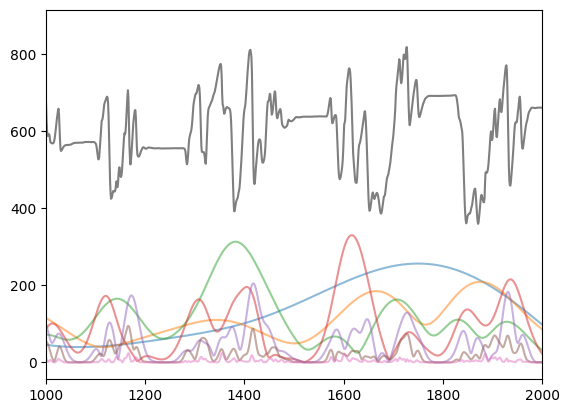

In [244]:
dt = np.round(np.mean(np.diff(corrected_l_paw_x_t)), 3)
paw_amp, Q, x_hat = fast_wavelet_morlet_convolution_parallel(donwsampled_l_paw_x[~np.isnan(donwsampled_l_paw_x)], f, omega0, dt)

plt.plot(paw_amp.T*15, alpha=.5)
plt.plot(donwsampled_l_paw_x[~np.isnan(donwsampled_l_paw_x)])
plt.xlim([1000, 2000])

In [199]:
def sliding_window_correlation(ts1_o, ts2_o, window_size):
    """
    Compute sliding window correlation between two time series.

    Parameters:
        ts1_o, ts2_o: 1D arrays (same length)
        window_size: size of the moving window (in samples)
    Returns:
        correlations: array of correlation values
    """
    ts1 = pd.Series(ts1_o.copy())
    ts2 = pd.Series(ts2_o.copy())
    
    return ts1.rolling(window=window_size, center=True).corr(ts2)

(10.0, 16.0)

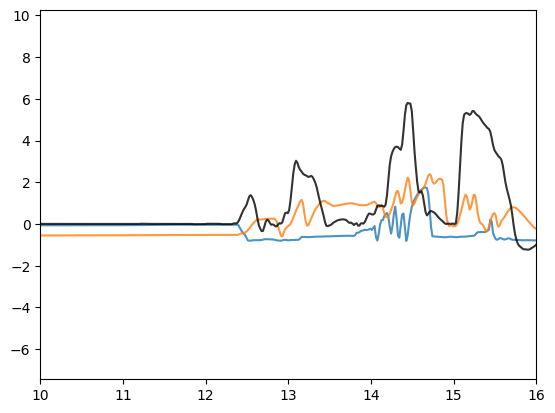

In [200]:
    plt.plot(design_matrix['Bin'], zscore(design_matrix['r_paw_x'], nan_policy='omit'), alpha=0.8, label='Right paw x')
    plt.plot(design_matrix['Bin'], zscore(design_matrix['l_paw_x'], nan_policy='omit'), alpha=0.8, label='Left paw x')
    plt.plot(design_matrix['Bin'], (design_matrix['avg_wheel_vel']), alpha=.8, color='k')
    plt.xlim([10, 16])

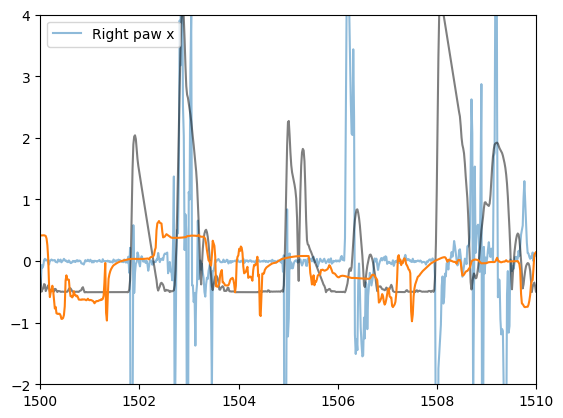

In [213]:
    plt.plot(design_matrix['Bin'][1:], zscore(np.diff(design_matrix['r_paw_x']), nan_policy='omit'), alpha=0.5, label='Right paw x')
    # plt.plot(design_matrix['Bin'], zscore(design_matrix['l_paw_x'], nan_policy='omit'), alpha=0.5, label='Left paw x')
    plt.plot(design_matrix['Bin'], zscore(np.abs(design_matrix['avg_wheel_vel'])), alpha=.5, color='k')
    # plt.vlines(trials_start, -20, 20, linestyles='--', color='k')
    # plt.title(session)
    correlations = sliding_window_correlation(zscore(np.diff(design_matrix['r_paw_x']), nan_policy='omit'), 
                                              zscore(np.abs(design_matrix['avg_wheel_vel']), nan_policy='omit')[1:], window_size=60)
    plt.plot(design_matrix['Bin'], correlations)

    trial_to_plot = 20

    beg = 1500
    end = 1510
    plt.xlim([beg, end])
    plt.ylim(-2, 4)
    # plt.ylim([-500, 500])
    
    plt.legend()
    plt.show()

2025-07-28 17:43:23 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-07-28 17:43:25 INFO     one.py:1288 Loading wheel data
2025-07-28 17:43:26 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-07-28 17:43:27 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-04", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


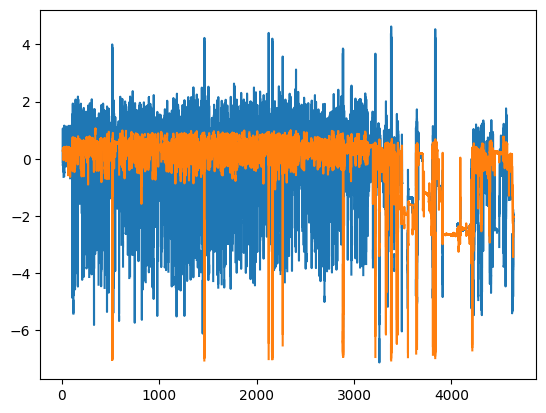

(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-30/2020-10-20/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 359M/359M [02:29<00:00, 2.39MB/s] 


2025-07-28 17:46:07 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-07-28 17:46:08 INFO     one.py:1288 Loading wheel data
2025-07-28 17:46:12 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-07-28 17:46:13 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-07-28 17:46:14 WARNING  one.py:1292 Could not load pupil data.


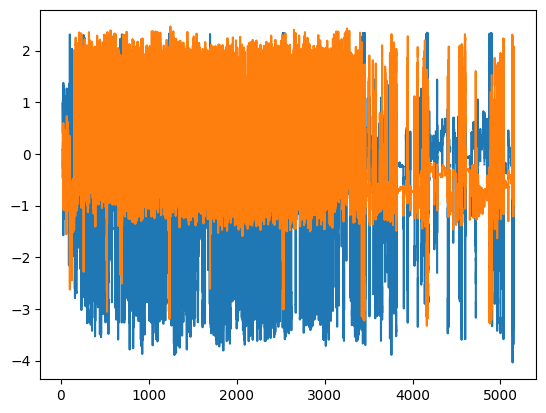

(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-30/2020-10-21/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 359M/359M [03:12<00:00, 1.86MB/s] 


2025-07-28 17:49:36 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-07-28 17:49:38 INFO     one.py:1288 Loading wheel data
2025-07-28 17:49:39 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-07-28 17:49:40 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-07-28 17:49:41 WARNING  one.py:1292 Could not load pupil data.


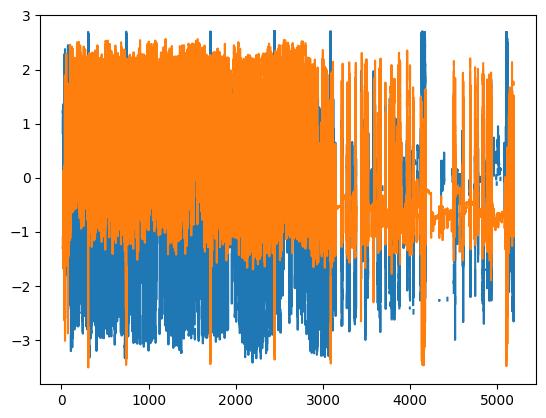

(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-30/2020-10-22/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 415M/415M [02:49<00:00, 2.44MB/s] 


2025-07-28 17:52:39 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-07-28 17:52:40 INFO     one.py:1288 Loading wheel data
2025-07-28 17:52:42 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-02"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-07-28 17:52:43 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-07-28 17:52:43 WARNING  one.py:1292 Could not load pupil data.


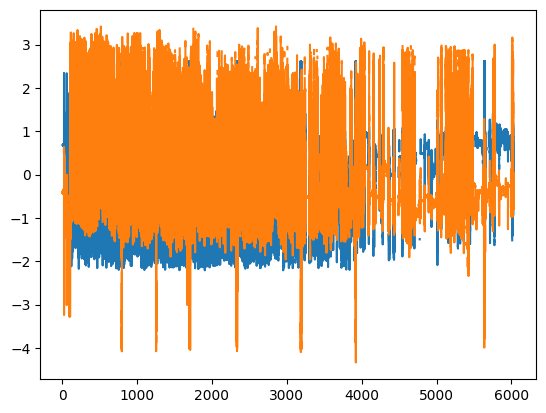

In [124]:
for session in sessions[:4]:
    file_path = one.eid2path(session)
    if prefix == '/home/ines/repositories/':
        mouse_name = file_path.parts[8]
    else:
        mouse_name = file_path.parts[7]

    """ LOAD VARIABLES """
    sl = SessionLoader(eid=session, one=one)
    sl.load_pose(views=['left', 'right'], tracker='lightningPose')
    sl.load_session_data(trials=True, wheel=True, motion_energy=True)

    # Check if all data is available
    if np.sum(sl.data_info['is_loaded']) >= 4:

        # Motion energy
        me = sl.motion_energy
        me_time = np.array(me['leftCamera']['times'])
        motion_energy = np.array(zscore(me['leftCamera']['whiskerMotionEnergy'], nan_policy='omit'))

        # Licks 
        features = ['tongue_end_l_x', 'tongue_end_l_y','tongue_end_r_x', 'tongue_end_r_y']        
        common_fs = 150 
        poses = sl.pose
        licks_time, licks = merge_licks(poses, features, common_fs)

        # Left paw
        l_paw_speeds = get_speed(poses['leftCamera'], poses['leftCamera']['times'], 'left', True, feature='paw_r')
        l_paw_time = np.array(l_paw_speeds['left'][0])
        # l_paw_x = l_paw_speeds['left'][1]
        # l_paw_y = l_paw_speeds['left'][2]
        # Right paw
        r_paw_speeds = get_speed(poses['rightCamera'], poses['rightCamera']['times'], 'right', True, feature='paw_r')
        r_paw_time = np.array(r_paw_speeds['right'][0])
        # r_paw_x = r_paw_speeds['right'][1]
        # r_paw_y = r_paw_speeds['right'][2]

        # Left paw
        l_paw_time = np.array(l_paw_speeds['left'][0])
        l_paw_x = interpolate_nans(poses['leftCamera']['paw_r_x'], 'left')
        l_paw_y = interpolate_nans(poses['leftCamera']['paw_r_y'], 'left')

        # Right paw
        r_paw_time = np.array(r_paw_speeds['right'][0])
        r_paw_x = interpolate_nans(poses['rightCamera']['paw_r_x'], 'right')
        r_paw_y = interpolate_nans(poses['rightCamera']['paw_r_y'], 'right')

        plt.plot(r_paw_time, zscore(poses['rightCamera']['paw_r_x'], nan_policy='omit'))
        plt.plot(l_paw_time, zscore(poses['leftCamera']['paw_r_x'], nan_policy='omit'))
        # plt.xlim(1000, 1050)
        plt.show()



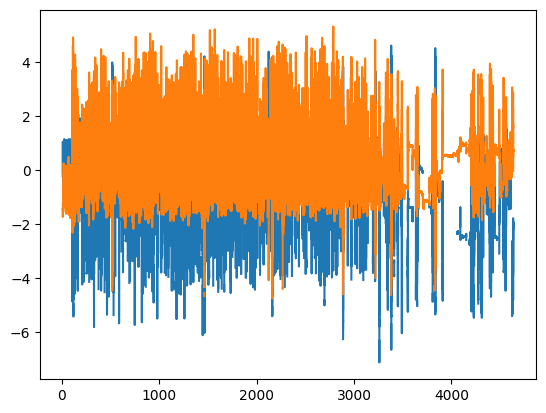

In [123]:
plt.plot(r_paw_time, zscore(poses['rightCamera']['paw_r_x'], nan_policy='omit'))
plt.plot(l_paw_time, zscore(poses['leftCamera']['paw_r_x'], nan_policy='omit'))
# plt.xlim(1000, 1050)


## Check sessions missing

In [104]:
# Loop through animals
function_name = process_design_matrix
sessions =  bwm_query['eid'].unique()
data_path =prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/v6_21Jul2025/' + str(bin_size) + '/'
os.chdir(data_path)
files = os.listdir()
sessions_to_process = []

for s, sess in enumerate(sessions):
    file_path = one.eid2path(sess)
    mouse_name = file_path.parts[8]
    filename = "design_matrix_" + str(sess) + '_'  + mouse_name
    if filename not in files:
        sessions_to_process.append((sess))

len(sessions_to_process)
        

218

# Design Matrix V5 15 Jan 2025

- Includes wavelet decomposition in addition to wheel velocity, licks and whisker motion energy
- Lower bin size

### Get sessions which pass QC

In [2]:
# Load preprocessed data
results_path = '/home/ines/repositories/representation_learning_variability/Video and wheel/Video QC/'
filename = str(results_path + 'custom_qc01-07-2025')
custom_qc = pickle.load(open(filename, "rb"))

### Parameters

In [3]:
bin_size = 0.1  # seconds
bin_size = 0.017  # np.round(1/60, 3)  # No binning, number indicates sampling rate
video_type = 'left'    
first_90 = False

# Wavelet decomposition
f = np.array([.25, .5, 1, 2, 4, 8, 16])
omega0 = 5

sessions =  custom_qc['eid'].unique()

In [4]:
def resample_common_time(reference_time, timestamps, data, kind, fill_gaps=None):
    # Function inspired on wh.interpolate from here: https://github.com/int-brain-lab/ibllib/blob/master/brainbox/behavior/wheel.py#L28 
    # t = np.arange(t_init, t_end, 1 / freq)  # Evenly resample at frequency
    if reference_time[-1] > timestamps[-1]:
        reference_time = reference_time[:-1]  # Occasionally due to precision errors the last sample may be outside of range.
    yinterp = interpolate.interp1d(timestamps, data, kind=kind, fill_value='extrapolate')(reference_time)
    
    if fill_gaps:
        #  Find large gaps and forward fill @fixme This is inefficient
        gaps, = np.where(np.diff(timestamps) >= fill_gaps)

        for i in gaps:
            yinterp[(reference_time >= timestamps[i]) & (reference_time < timestamps[i + 1])] = data[i]
            
    return yinterp, reference_time


def morlet_conj_ft(omega_vals, omega0):
    """
    Computes the conjugate Fourier transform of the Morlet wavelet.
    
    Parameters:
    - w: Angular frequency values (array or scalar)
    - omega0: Dimensionless Morlet wavelet parameter
    
    Returns:
    - out: Conjugate Fourier transform of the Morlet wavelet
    """
    
    return np.pi**(-1/4) * np.exp(-0.5 * (omega_vals - omega0)**2)


def fast_wavelet_morlet_convolution_parallel(x, f, omega0, dt):
    """
    Fast Morlet wavelet transform using parallel computation.

    Args:
        x (array): 1D array of projection values to transform.
        f (array): Center frequencies of the wavelet frequency channels (Hz).
        omega0 (float): Dimensionless Morlet wavelet parameter.
        dt (float): Sampling time (seconds).

    Returns:
        amp (array): Wavelet amplitudes.
        W (array): Wavelet coefficients (complex-valued, optional).
    """
    N = len(x)
    L = len(f)
    amp = np.zeros((L, N))
    Q = np.zeros((L, N))

    # Ensure N is even
    if N % 2 == 1:
        x = np.append(x, 0)
        N += 1
        test = True
    else:
        test = False

    # Add zero padding to x
    # Zero padding serves to compensate for the fact that the kernel does not have the same size as 
    # 
    x = np.concatenate((np.zeros(N // 2), x, np.zeros(N // 2)))
    M = N
    N = len(x)

    # Compute scales
    scales = (omega0 + np.sqrt(2 + omega0**2)) / (4 * np.pi * f)
    # angular frequencies to compute FT for (depends on sampling frequency); is as long as N 
    omega_vals = 2 * np.pi * np.arange(-N // 2, N // 2) / (N * dt)  

    # Fourier transform of x; shift folds it around zero so that it is more interpretable (frequencies at the right of nyquist become negative)
    x_hat = fftshift(fft(x))

    # Index for truncation to recover the actual x without padding
    if test:
        idx = np.arange(M // 2, M // 2 + M - 1)
    else:
        idx = np.arange(M // 2, M // 2 + M)

    # Function for parallel processing
    def process_frequency(i):
        # Take the Morlet conjugate of the Fourier transform
        m = morlet_conj_ft(-omega_vals * scales[i], omega0)
        # Convolution on the Fourier domain (as opposed to time domain in DWT)
        conv = m * x_hat
        # Inverse Fourier transform (normalized?)
        # q are the wavelet coefficients; normalized to ensure the energy of the wavelet is preserved across different scales
        q = ifft(conv) * np.sqrt(scales[i])
        # Recover q without padding
        q = q[idx]
        amp_row = np.abs(q) * np.pi**-0.25 * np.exp(0.25 * (omega0 - np.sqrt(omega0**2 + 2))**2) / np.sqrt(2 * scales[i])
        return amp_row, q

    # Parallel processing
    results = Parallel(n_jobs=-1)(delayed(process_frequency)(i) for i in range(L))

    for i, (amp_row, q) in enumerate(results):
        amp[i, :] = amp_row
        Q[i, :] = q

    return amp, Q, x_hat

In [5]:
def process_design_matrix(session):

    file_path = one.eid2path(session)
    mouse_name = file_path.parts[8]

    """ LOAD VARIABLES """
    # Licks
    video_time, lick_on = get_lick_on(one, session, video_type)

    # Motion energy of whisker pad
    me_times, me = get_ME(one, session, video_type)    
    motion_energy = zscore(me, nan_policy='omit') 
    assert len(video_time) == len(me_times), print('ME and lick times do not match!')

    # Wheel
    wheel = one.load_object(session, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

    """ COMMON TIMESTAMPS AND RESAMPLING"""
    # Use video time as reference, truncate to fit wheel_times
    reference_time = video_time.copy()
    onset = np.max([np.min(video_time), np.min(wheel_times)])
    offset = np.min([np.max(video_time), np.max(wheel_times)])
    reference_time = reference_time[np.where(video_time > onset)[0][0]:np.where(video_time < offset)[0][-1]]

    # Truncate all other variables based on onset and offset, before downsampling
    lick_on = lick_on[np.where(video_time > onset)[0][0]:np.where(video_time < offset)[0][-1]]
    motion_energy = motion_energy[np.where(me_times > onset)[0][0]:np.where(me_times < offset)[0][-1]]
    pos = pos[np.where(wheel_times > onset)[0][0]:np.where(wheel_times < offset)[0][-1]]
    wheel_times = wheel_times[np.where(wheel_times > onset)[0][0]:np.where(wheel_times < offset)[0][-1]]

    # Downsample
    donwsampled_wheel, corrected_wheel_t = resample_common_time(reference_time, wheel_times, pos, kind='linear', fill_gaps=None)

    # Check data integrity
    assert len(reference_time) == len(corrected_wheel_t)
    assert len(reference_time) == len(donwsampled_wheel)
    assert len (reference_time) == len(motion_energy)
    assert len (reference_time) == len(lick_on)
        
    # Wavelet decomposition of wheel velocity
    wheel_vel = np.diff(donwsampled_wheel)
    dt = np.round(np.mean(np.diff(corrected_wheel_t)), 3)
    amp, _, _ = fast_wavelet_morlet_convolution_parallel(wheel_vel, f, omega0, dt)

    """ GROUP DATA INTO DESIGN MATRIX """
    design_matrix = pd.DataFrame(columns=['Bin', 'avg_wheel_vel', 'whisker_me', 'Lick count'])
    design_matrix['Bin'] = reference_time.copy()
    design_matrix['Lick count'] = lick_on.copy()
    design_matrix['avg_wheel_vel'][:-1] = wheel_vel.copy()
    design_matrix['whisker_me'] = motion_energy.copy()

    # Wavelet transforms
    for i, frequency in enumerate(f):
        # Create new column with frequency
        design_matrix[str(frequency)] = design_matrix['Bin'] * np.nan
        design_matrix[str(frequency)][:-1] = amp[i, :]
        
    """ LOAD TRIAL DATA """
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_start = list(session_trials['goCueTrigger_times'])[0]

    # Get time of last unbiased trial
    unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
    time_trial_90 = list(unbiased['stimOff_times'])[-1]

    if first_90 == True:
        # Keep only first 90 trials
        design_matrix = design_matrix.loc[(design_matrix['Bin'] < time_trial_90) & 
                                            (design_matrix['Bin'] > session_start)]
        use_trials = session_trials.loc[session_trials['stimOff_times'] < time_trial_90]
    else:
        design_matrix = design_matrix.loc[(design_matrix['Bin'] > session_start)]
        use_trials = session_trials.copy()

    """ STANDARDIZE DATA """
    training_set = np.array(design_matrix).copy()[:, 1:]
    # Standardization using StandardScaler
    scaler = StandardScaler()
    std_design_matrix = scaler.fit_transform(training_set)
    # Keep licks unnormalized
    std_design_matrix[:, 2] = training_set[:, 2]  

    """ SAVE DATA """       
    # Save unnormalized design matrix
    data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/v5_15Jan2025/' + str(bin_size) + '/'
    filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
    design_matrix.to_parquet(filename, compression='gzip')  

    # Save standardized design matrix
    data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/v5_15Jan2025/' + str(bin_size) + '/'
    filename = data_path + "standardized_design_matrix_" + str(session) + '_'  + mouse_name
    np.save(filename, std_design_matrix)

    # Save trials
    data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/v5_15Jan2025/' + str(bin_size) + '/'
    filename = data_path + "session_trials_" + str(session) + '_'  + mouse_name
    use_trials.to_parquet(filename, compression='gzip')  
    
    del design_matrix, std_design_matrix, use_trials
    gc.collect()
    
def parallel_process_data(sessions, function_name):
    with concurrent.futures.ThreadPoolExecutor() as executor:

        # Process each chunk in parallel
        executor.map(function_name, sessions)


## Check sessions missing

In [12]:
# Loop through animals
function_name = process_design_matrix
sessions =  custom_qc['eid'].unique()
data_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/v5_15Jan2025/' + str(bin_size) + '/'
os.chdir(data_path)
files = os.listdir()
sessions_to_process = []

for s, sess in enumerate(sessions):
    file_path = one.eid2path(sess)
    mouse_name = file_path.parts[8]
    filename = "design_matrix_" + str(sess) + '_'  + mouse_name
    if filename not in files:
        sessions_to_process.append((sess))
        

## Process sessions in series

In [11]:
for s, session in enumerate(sessions_to_process):
    process_design_matrix(session)

/tmp/ipykernel_29322/3471468597.py:100: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_29322/3753953485.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  design_matrix['avg_wheel_vel'][:-1] = wheel_vel.copy()
/tmp/ipykernel_29322/3753953485.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  design_matrix[str(frequency)][:-1] = amp[i, :]
/tmp/ipykernel_29322/3753953485.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

## Process sessions missing in parallel

In [18]:
# Loop through animals
function_name = process_design_matrix
bundle_size = 2
loop_times = len(sessions_to_process)//bundle_size
for l in range(loop_times):
    start_idx = l*bundle_size
    end_idx = l*bundle_size+bundle_size
    use_sessions = sessions_to_process[start_idx:end_idx]
    parallel_process_data(use_sessions, function_name)  # TODO: figure how to use params inside these functions


KeyboardInterrupt: 

# Design Matrix V4 9 Dec 2024

- Same as V4 but only includes wheel velocity, licks and whisker motion energy

### Parameters

In [2]:
bin_size = 0.1  # seconds
video_type = 'left'    

In [3]:
# data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Brainwidemap/'
# # data_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Brainwidemap/'

# os.chdir(data_path)https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-022-29600-1/MediaObjects/41467_2022_29600_MOESM1_ESM.pdf
ext_qc_path = '/home/ines/repositories/representation_learning_variability/Video and wheel/Video QC/'
os.chdir(ext_qc_path)
lick_custom = pickle.load(open(ext_qc_path + "dlc_left_extended_lick01-03-2025", "rb"))
# Filter based on custom lick qc and some key video qcs
final_custom_qc = lick_custom.loc[(lick_custom['dlcLeft'].isin(['FAIL', 'WARNING', 'PASS', np.nan])) &
                (lick_custom['videoLeft'].isin(['FAIL', 'WARNING', 'PASS', np.nan])) &
                (lick_custom['ratio']>5) &
                (lick_custom['_videoLeft_pin_state'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &
                (lick_custom['_videoLeft_framerate'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &  
                (lick_custom['_videoLeft_camera_times'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &
                (lick_custom['_videoLeft_dropped_frames'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS' or x == None)) &
                (lick_custom['_videoLeft_timestamps'].isin([True, 'PASS', np.nan]))                   
                ]
    
custom_qc_eids = final_custom_qc['eid'].unique() 


In [4]:
def process_design_matrix(session):
    bin_size = 0.1
    video_type = 'left'

    file_path = one.eid2path(session)
    mouse_name = file_path.parts[8]

    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()

    # Licks
    session_licks = get_lick_times(one, session, combine=False, video_type=video_type)

    # Wheel
    wheel = one.load_object(session, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)
    
    # Motion energy of whisker pad
    me_times, motion_energy = get_ME(one, session, video_type)       
    motion_energy = zscore(motion_energy, nan_policy='omit') 


    # Initialize dataframe
    licking = lick_rate(bin_size, session_licks, session_trials)
    wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
    # wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=True)
    whisker_me = cont_bin(me_times, motion_energy, session_trials, bin_size)

    # Rename column names
    whisker_me = whisker_me.rename(columns={'Values':'whisker_me'})
    
    # Merge all tables
    all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].dropna().merge(licking[['Bin', 'Lick count']], on='Bin', how='outer')
    # all_metrics = all_metrics.merge(wheel_disp[['Bin', 'wheel_final']], on='Bin', how='outer')
    all_metrics = all_metrics.merge(whisker_me[['Bin', 'whisker_me']], on='Bin', how='outer')

    # Remove Nans before adding more data or else this breaks (not sure if this is really tru, but worked like this)
    all_metrics['Lick count'] = all_metrics['Lick count'].replace(np.NaN, 0)
    all_metrics = all_metrics.dropna().drop_duplicates()

    # Save design matrix
    data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/v4_9Dec2024/' + str(bin_size) + '/'
    os.chdir(data_path)
    pickle.dump(all_metrics, open("design_matrix_" + str(session) + '_'  + mouse_name + '_' + str(bin_size), "wb"))


def parallel_process_data(sessions, function_name):
    with concurrent.futures.ThreadPoolExecutor() as executor:

        # Process each chunk in parallel
        executor.map(function_name, sessions)

In [10]:
# Loop through sessions one by one
function_name = process_design_matrix
data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/v4_9Dec2024/' + str(bin_size) + '/'
os.chdir(data_path)
files = os.listdir()

for s, sess in enumerate(custom_qc_eids):
    file_path = one.eid2path(sess)
    mouse_name = file_path.parts[8]

    filename = "design_matrix_" + str(sess) + '_'  + mouse_name + '_' + str(bin_size)
    if filename not in files:
        process_design_matrix(sess)
        # parallel_process_data([sess], function_name)

# Design Matrix V4 5 Jul 2024

- V3 includes data to be used on 'movement detector' 2ARHMMs
- Includes no pupil data because it is not trustworthy
- Includes the two paws

### Get sessions from mice of interest

In [6]:
# Choose a session with good QC
data_path = '/home/ines/repositories/representation_learning_variability/Video and wheel/'
# data_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Video and wheel/'

os.chdir(data_path)
pass_qc = pickle.load(open(data_path + "good_brainwide_sessions_metadata", "rb"))
pass_qc = pickle.load(open(data_path + "good_dlc_bwm_sessions_metadata", "rb"))
# mouse_names = pass_qc['subject_nickname'].unique()

### Parameters

In [2]:
bin_size = 0.1  # seconds
video_type = 'left'    

## Compute frame rate per session - not necessary if using the custom/extended QC

In [20]:
frame_rate = pass_qc.copy()
frame_rate['frame_rate'] = np.zeros(len(pass_qc)) * np.nan
for s, session in enumerate(pass_qc['session_uuid']):
    try:
        
        mouse_name = pass_qc['subject_nickname'][s]
        dlc_times, XYs = get_dlc_XYs(one, session, view=video_type, likelihood_thresh=0.9)
        frt = 1/np.mean(np.diff(dlc_times))
        
        # Save
        frame_rate.loc[(frame_rate['subject_nickname']==mouse_name) & 
                       (frame_rate['session_uuid']==session), 'frame_rate'] = frt

    except:
       print(session)

# Save design matrix
data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/frame_rate/'
os.chdir(data_path)
pickle.dump(frame_rate, open("frame_rate", "wb"))

# Run code in parallel

In [17]:
# Loop through animals
function_name = process_design_matrix
sessions = pass_qc['session_uuid']
# sessions = list(pass_qc.loc[pass_qc['subject_nickname']=='CSHL045', 'session_uuid'])
data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/v4_5Jul2024/' + str(bin_size) + '/'
os.chdir(data_path)
files = os.listdir()
for s, sess in enumerate(sessions):
    mouse_name = list(pass_qc.loc[pass_qc['session_uuid']==sess, 'subject_nickname'])[0]
    filename = "design_matrix_" + str(sess) + '_'  + mouse_name + '_' + str(bin_size)
    if filename not in files:
        parallel_process_data([sess], function_name)

d32876dd-8303-4720-8e7e-20678dc2fd71
72982282-e493-45ee-87ce-aa45cb3a3ec1
6434f2f5-6bce-42b8-8563-d93d493613a2
64e3fb86-928c-4079-865c-b364205b502e
15948667-747b-4702-9d53-354ac70e9119
288bfbf3-3700-4abe-b6e4-130b5c541e61
fc43390d-457e-463a-9fd4-b94a0a8b48f5
3d59aa1a-b4ba-47fe-b9cf-741b5fdb0c7b
6364ff7f-6471-415a-ab9e-632a12052690


local md5 mismatch on dataset: cortexlab/Subjects/KS014/2019-12-07/001/alf/_ibl_trials.goCueTrigger_times.npy


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS014/2019-12-07/001/alf/_ibl_trials.goCueTrigger_times.bc2892ec-a74f-4697-ab1f-42ccf0a00443.npy Bytes: 5384


100%|██████████| 0.00513458251953125/0.00513458251953125 [00:00<00:00,  1.70s/it]
local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.npy


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.624b4901-d15f-40b4-97af-f9f72d74a51c.npy Bytes: 5352


100%|██████████| 0.00510406494140625/0.00510406494140625 [00:00<00:00,  1.29it/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-08/001/alf/_ibl_trials.goCueTrigger_times.npy


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-08/001/alf/_ibl_trials.goCueTrigger_times.60917ccf-cc92-4430-9006-81ee13118d9d.npy Bytes: 6528


100%|██████████| 0.0062255859375/0.0062255859375 [00:00<00:00,  1.35it/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-10/001/alf/_ibl_trials.goCueTrigger_times.npy


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-10/001/alf/_ibl_trials.goCueTrigger_times.16c81eaf-a032-49cd-9823-09c0c7350fd2.npy Bytes: 5256


100%|██████████| 0.00501251220703125/0.00501251220703125 [00:00<00:00,  1.15it/s]


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS051/2021-05-11/001/alf/#2024-07-15#/_ibl_trials.stimOffTrigger_times.9b98c742-59d2-40d4-a3ec-de60cbb8bded.npy Bytes: 3952
Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS051/2021-05-11/001/alf/#2024-07-15#/_ibl_trials.stimOnTrigger_times.41977da1-f395-4c59-b525-41be3b3d1032.npy Bytes: 3952


100%|██████████| 0.0037689208984375/0.0037689208984375 [00:00<00:00,  3.52s/it]
100%|██████████| 0.0037689208984375/0.0037689208984375 [00:00<00:00,  2.70s/it]


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS051/2021-05-11/001/alf/#2024-07-15#/_ibl_trials.table.12ddae0c-b285-4100-8d06-5e2cde23efe4.pqt Bytes: 41394


  0%|          | 0/0.03947639465332031 [00:00<?, ?it/s]

Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS051/2021-05-11/001/alf/#2024-07-15#/_ibl_trials.stimOff_times.87c297e1-fd1f-4d4f-9e8d-73b4a77339a4.npy Bytes: 3952


100%|██████████| 0.0037689208984375/0.0037689208984375 [00:00<00:00,  1.72s/it]
100%|██████████| 0.03947639465332031/0.03947639465332031 [00:00<00:00,  6.89s/it]


b22f694e-4a34-4142-ab9d-2556c3487086
90d1e82c-c96f-496c-ad4e-ee3f02067f25
68775ca0-b056-48d5-b6ae-a4c2a76ae48f
1b61b7f2-a599-4e40-abd6-3e758d2c9e25


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


4ecb5d24-f5cc-402c-be28-9d0f7cb14b3a
d7e60cc3-6020-429e-a654-636c6cc677ea
113c5b6c-940e-4b21-b462-789b4c2be0e5
d0c91c3c-8cbb-4929-8657-31f18bffc294
Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02373/2021-06-23/001/alf/#2024-07-15#/_ibl_trials.table.0d2c5d9c-8504-49f5-9869-01deafadffab.pqt Bytes: 37866
Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02373/2021-06-23/001/alf/#2024-07-15#/_ibl_trials.stimOnTrigger_times.242db3e0-b786-4872-af4b-c6b38d8ce7d7.npy Bytes: 3520


100%|██████████| 0.00335693359375/0.00335693359375 [00:00<00:00,  2.72s/it]

Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02373/2021-06-23/001/alf/#2024-07-15#/_ibl_trials.stimOffTrigger_times.8995d9e2-8f9c-4588-bc54-28df41a6ef12.npy Bytes: 3520
Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02373/2021-06-23/001/alf/#2024-07-15#/_ibl_trials.stimOff_times.ad538c37-b49c-487c-8eb3-56b34dc15ff8.npy Bytes: 3520






100%|██████████| 0.00335693359375/0.00335693359375 [00:00<00:00,  1.45s/it]
100%|██████████| 0.00335693359375/0.00335693359375 [00:00<00:00,  1.45it/s]
100%|██████████| 0.03611183166503906/0.03611183166503906 [00:00<00:00,  7.44s/it]


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_038/2020-08-01/001/alf/#2024-07-15#/_ibl_trials.stimOffTrigger_times.8111b093-62fc-4571-b85f-df7584beeb7c.npy Bytes: 7064
Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_038/2020-08-01/001/alf/#2024-07-15#/_ibl_trials.table.162fe3af-1337-494b-a8ad-3c392751e2fb.pqt Bytes: 66658


  0%|          | 0/0.00673675537109375 [00:00<?, ?it/s]

Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_038/2020-08-01/001/alf/#2024-07-15#/_ibl_trials.stimOff_times.accbfe5b-12ac-43c9-9f01-90453abb2d97.npy Bytes: 7064
Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_038/2020-08-01/001/alf/#2024-07-15#/_ibl_trials.stimOnTrigger_times.485cd50d-2dff-4bed-8abc-2e9ffabb564b.npy Bytes: 7064


100%|██████████| 0.00673675537109375/0.00673675537109375 [00:00<00:00,  2.08it/s]



100%|██████████| 0.00673675537109375/0.00673675537109375 [00:00<00:00,  2.84it/s]
100%|██████████| 0.00673675537109375/0.00673675537109375 [00:00<00:00,  4.65it/s]
100%|██████████| 0.06357002258300781/0.06357002258300781 [00:00<00:00,  4.87s/it]


fc14c0d6-51cf-48ba-b326-56ed5a9420c3
22e04698-b974-4805-b241-3b547dbf37bf
Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0027/2022-08-22/001/alf/#2024-07-15#/_ibl_trials.stimOnTrigger_times.141af070-0d8d-402c-a2b6-07a676b87e7a.npy Bytes: 9656
Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0027/2022-08-22/001/alf/#2024-07-15#/_ibl_trials.table.9b96ebd5-baa8-4f82-854b-bba25e481cd2.pqt Bytes: 89876
Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0027/2022-08-22/001/alf/#2024-07-15#/_ibl_trials.stimOff_times.770c4d55-8136-4cff-86e1-f5621e90cb32.npy Bytes: 9656
Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0027/2022-08-22/001/alf/#2024-07-15#/_ibl_trials.stimOffTrigger_times.5b1591b8-015a-470a-9d23-1a8853cc0c0a.npy Bytes: 9656


  0%|          | 0/0.00920867919921875 [00:00<?, ?it/s]


100%|██████████| 0.00920867919921875/0.00920867919921875 [00:00<00:00,  1.79it/s]
100%|██████████| 0.00920867919921875/0.00920867919921875 [00:00<00:00,  1.28s/it]
100%|██████████| 0.00920867919921875/0.00920867919921875 [00:00<00:00,  3.15it/s]
100%|██████████| 0.08571243286132812/0.08571243286132812 [00:00<00:00,  5.31s/it]


09394481-8dd2-4d5c-9327-f2753ede92d7
Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-09/002/alf/#2024-07-15#/_ibl_trials.table.d23becf3-4d56-49a7-9bc9-03d63c092872.pqt Bytes: 47528


  0%|          | 0/0.04532623291015625 [00:00<?, ?it/s]

Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-09/002/alf/#2024-07-15#/_ibl_trials.stimOnTrigger_times.626c8ca4-d274-4e2e-bb8a-3fca5c0ece42.npy Bytes: 4632


100%|██████████| 0.00441741943359375/0.00441741943359375 [00:00<00:00,  1.09s/it]


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-09/002/alf/#2024-07-15#/_ibl_trials.stimOff_times.ec4d2e83-6966-4e22-b32f-8d68c44ebe2f.npy Bytes: 4632


100%|██████████| 0.00441741943359375/0.00441741943359375 [00:00<00:00,  2.16it/s]
100%|██████████| 0.04532623291015625/0.04532623291015625 [00:00<00:00,  6.49s/it]


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-09/002/alf/#2024-07-15#/_ibl_trials.stimOffTrigger_times.910276d1-dd24-43cd-ac4b-c5efc58b5c58.npy Bytes: 4632


100%|██████████| 0.00441741943359375/0.00441741943359375 [00:00<00:00,  1.31it/s]


In [9]:
# Loop through animals
function_name = process_design_matrix
sessions = pass_qc['session_uuid']
loop_times = int(np.ceil(len(sessions)/5))  # tried to run 10 sessions in parallel but it breaks

for l in range(loop_times):
    start_idx = l*5
    end_idx = l*5+5
    use_sessions = sessions[start_idx:end_idx]
    parallel_process_data(use_sessions, function_name)

64e3fb86-928c-4079-865c-b364205b502e
d32876dd-8303-4720-8e7e-20678dc2fd71
6434f2f5-6bce-42b8-8563-d93d493613a2
15948667-747b-4702-9d53-354ac70e9119
72982282-e493-45ee-87ce-aa45cb3a3ec1
288bfbf3-3700-4abe-b6e4-130b5c541e61
fc43390d-457e-463a-9fd4-b94a0a8b48f5
3d59aa1a-b4ba-47fe-b9cf-741b5fdb0c7b


local md5 mismatch on dataset: churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.60k/4.60k [00:00<00:00, 7.21kB/s]


6364ff7f-6471-415a-ab9e-632a12052690


local md5 mismatch on dataset: cortexlab/Subjects/KS014/2019-12-03/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS014/2019-12-03/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.38k/4.38k [00:00<00:00, 7.10kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-08/001/alf/_ibl_trials.goCueTrigger_times.npy
local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.npy
local md5 mismatch on dataset: cortexlab/Subjects/KS014/2019-12-07/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.npy:   0%|          | 0.00/5.35k [00:00<?, ?B/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.35k/5.35k [00:00<00:00, 9.97kB/s]

/

: 

: 

In [5]:
def process_design_matrix(session):
    bin_size = 0.1
    try:
        
        mouse_name = list(pass_qc.loc[pass_qc['session_uuid']==session, 'subject_nickname'])[0]

        session_trials = one.load_object(session, obj='trials', namespace='ibl')
        session_trials = session_trials.to_df()

        # Licks
        session_licks = get_lick_times(one, session, combine=False, video_type=video_type)

        # Wheel
        wheel = one.load_object(session, 'wheel', collection='alf')
        pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

        # # Pupil diameter
        # pupil_dia_raw, pupil_dia_smooth, _, _ = (
        #     get_raw_and_smooth_position(one, session, video_type, ephys=True, position_function=get_pupil_diameter))
        dlc_times, XYs = get_dlc_XYs(one, session, view=video_type, likelihood_thresh=0.9)
        
        # # Pupil position
        # pupil_X, pupil_Y = pupil_center(XYs)
        
        # Motion energy of whisker pad
        me_times, motion_energy = get_ME(one, session, video_type)       
        motion_energy = zscore(motion_energy, nan_policy='omit') 
        
        # Nose positions
        nose_X, nose_Y = nose_tip(XYs)

        # Left paw positions
        left_paw_X, left_paw_Y = left_paw(XYs)
        
        # Right paw positions
        right_paw_X, right_paw_Y = right_paw(XYs)
        
        # Get session values
        # session_length = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
        # n_bins = int(np.floor(session_length/bin_size))
        # onsets = session_trials['stimOn_times']

        # Initialize dataframe
        licking = lick_rate(bin_size, session_licks, session_trials)
        wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
        wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=True)
        # pupil_dia = pupil_diam(dlc_times, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=True)
        whisker_me = cont_bin(me_times, motion_energy, session_trials, bin_size)
        left_X = cont_bin(dlc_times, left_paw_X, session_trials, bin_size)
        left_Y = cont_bin(dlc_times, left_paw_Y, session_trials, bin_size)
        right_X = cont_bin(dlc_times, right_paw_X, session_trials, bin_size)
        right_Y = cont_bin(dlc_times, right_paw_Y, session_trials, bin_size)
        # pupil_X_pos = cont_bin(dlc_times, pupil_X, session_trials, bin_size)
        # pupil_Y_pos = cont_bin(dlc_times, pupil_Y, session_trials, bin_size)
        nose_X_pos = cont_bin(dlc_times, nose_X, session_trials, bin_size)
        nose_Y_pos = cont_bin(dlc_times, nose_Y, session_trials, bin_size)
        
        # Rename column names
        # pupil_dia = pupil_dia.rename(columns={'pupil_final':'pupil_diameter'})
        whisker_me = whisker_me.rename(columns={'Values':'whisker_me'})
        left_X = left_X.rename(columns={'Values':'left_X'})
        left_Y = left_Y.rename(columns={'Values':'left_Y'})
        right_X = right_X.rename(columns={'Values':'right_X'})
        right_Y = right_Y.rename(columns={'Values':'right_Y'})
        # pupil_X_pos = pupil_X_pos.rename(columns={'Values':'pupil_X'})
        # pupil_Y_pos = pupil_Y_pos.rename(columns={'Values':'pupil_Y'})   
        nose_X_pos = nose_X_pos.rename(columns={'Values':'nose_X'})
        nose_Y_pos = nose_Y_pos.rename(columns={'Values':'nose_Y'})     
        
        # Merge all tables
        all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].dropna().merge(licking[['Bin', 'Lick count']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(wheel_disp[['Bin', 'wheel_final']], on='Bin', how='outer')
        # all_metrics = all_metrics.merge(pupil_dia[['Bin', 'pupil_diameter']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(whisker_me[['Bin', 'whisker_me']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_X[['Bin', 'left_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_Y[['Bin', 'left_Y']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(right_X[['Bin', 'right_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(right_Y[['Bin', 'right_Y']], on='Bin', how='outer')
        # all_metrics = all_metrics.merge(pupil_X_pos[['Bin', 'pupil_X']], on='Bin', how='outer')
        # all_metrics = all_metrics.merge(pupil_Y_pos[['Bin', 'pupil_Y']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(nose_X_pos[['Bin', 'nose_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(nose_Y_pos[['Bin', 'nose_Y']], on='Bin', how='outer')

        # Remove Nans before adding more data or else this breaks (not sure if this is really tru, but worked like this)
        all_metrics['Lick count'] = all_metrics['Lick count'].replace(np.NaN, 0)
        all_metrics = all_metrics.dropna().drop_duplicates()

        # Save design matrix
        data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/v4_5Jul2024/' + str(bin_size) + '/'
        os.chdir(data_path)
        pickle.dump(all_metrics, open("design_matrix_" + str(session) + '_'  + mouse_name + '_' + str(bin_size), "wb"))

    except:
       print(session)

def parallel_process_data(sessions, function_name):
    with concurrent.futures.ThreadPoolExecutor() as executor:

        # Process each chunk in parallel
        executor.map(function_name, sessions)

# Design Matrix V3

- V3 includes data to be used on 'movement detector' 2ARHMMs

In [4]:
def process_design_matrix(session):
    bin_size = 0.1
    try:
        
        mouse_name = list(pass_qc.loc[pass_qc['session_uuid']==session, 'subject_nickname'])[0]

        session_trials = one.load_object(session, obj='trials', namespace='ibl')
        session_trials = session_trials.to_df()

        # Licks
        session_licks = get_lick_times(one, session, combine=False, video_type=video_type)

        # Wheel
        wheel = one.load_object(session, 'wheel', collection='alf')
        pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

        # Pupil diameter
        pupil_dia_raw, pupil_dia_smooth, _, _ = (
            get_raw_and_smooth_position(one, session, video_type, ephys=True, position_function=get_pupil_diameter))
        dlc_times, XYs = get_dlc_XYs(one, session, view=video_type, likelihood_thresh=0.9)
        
        # Pupil position
        pupil_X, pupil_Y = pupil_center(XYs)
        
        # Motion energy of whisker pad
        me_times, motion_energy = get_ME(one, session, video_type)       
        motion_energy = zscore(motion_energy, nan_policy='omit') 
        
        # Nose positions
        nose_X, nose_Y = nose_tip(XYs)

        # Left paw positions
        left_paw_X, left_paw_Y = left_paw(XYs)
        
        # Right paw positions
        right_paw_X, right_paw_Y = right_paw(XYs)
        
        # Get session values
        session_length = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
        n_bins = int(np.floor(session_length/bin_size))
        onsets = session_trials['stimOn_times']

        # Initialize dataframe
        licking = lick_rate(bin_size, session_licks, session_trials)
        wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
        wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=True)
        pupil_dia = pupil_diam(dlc_times, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=True)
        whisker_me = cont_bin(me_times, motion_energy, session_trials, bin_size)
        left_X = cont_bin(dlc_times, left_paw_X, session_trials, bin_size)
        left_Y = cont_bin(dlc_times, left_paw_Y, session_trials, bin_size)
        right_X = cont_bin(dlc_times, right_paw_X, session_trials, bin_size)
        right_Y = cont_bin(dlc_times, right_paw_Y, session_trials, bin_size)
        pupil_X_pos = cont_bin(dlc_times, pupil_X, session_trials, bin_size)
        pupil_Y_pos = cont_bin(dlc_times, pupil_Y, session_trials, bin_size)
        nose_X_pos = cont_bin(dlc_times, nose_X, session_trials, bin_size)
        nose_Y_pos = cont_bin(dlc_times, nose_Y, session_trials, bin_size)
        
        # Rename column names
        pupil_dia = pupil_dia.rename(columns={'pupil_final':'pupil_diameter'})
        whisker_me = whisker_me.rename(columns={'Values':'whisker_me'})
        left_X = left_X.rename(columns={'Values':'left_X'})
        left_Y = left_Y.rename(columns={'Values':'left_Y'})
        right_X = right_X.rename(columns={'Values':'right_X'})
        right_Y = right_Y.rename(columns={'Values':'right_Y'})
        pupil_X_pos = pupil_X_pos.rename(columns={'Values':'pupil_X'})
        pupil_Y_pos = pupil_Y_pos.rename(columns={'Values':'pupil_Y'})   
        nose_X_pos = nose_X_pos.rename(columns={'Values':'nose_X'})
        nose_Y_pos = nose_Y_pos.rename(columns={'Values':'nose_Y'})     
        
        # Merge all tables
        all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].dropna().merge(licking[['Bin', 'Lick count']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(wheel_disp[['Bin', 'wheel_final']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil_dia[['Bin', 'pupil_diameter']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(whisker_me[['Bin', 'whisker_me']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_X[['Bin', 'left_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_Y[['Bin', 'left_Y']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(right_X[['Bin', 'right_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(right_Y[['Bin', 'right_Y']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil_X_pos[['Bin', 'pupil_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil_Y_pos[['Bin', 'pupil_Y']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(nose_X_pos[['Bin', 'nose_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(nose_Y_pos[['Bin', 'nose_Y']], on='Bin', how='outer')

        # Remove Nans before adding more data or else this breaks (not sure if this is really tru, but worked like this)
        all_metrics['Lick count'] = all_metrics['Lick count'].replace(np.NaN, 0)
        all_metrics = all_metrics.dropna().drop_duplicates()

        # Save design matrix
        data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/v3_5Jul2024/' + str(bin_size) + '/'
        os.chdir(data_path)
        pickle.dump(all_metrics, open("design_matrix_" + str(session) + '_'  + mouse_name + '_' + str(bin_size), "wb"))

    except:
       print(session)

def parallel_process_data(sessions, function_name):
    with concurrent.futures.ThreadPoolExecutor() as executor:

        # Process each chunk in parallel
        executor.map(function_name, sessions)

# Design matrix V1

In [4]:
for s, session in enumerate(pass_qc['session_uuid'][0:1]):
    # TODO: as it is this takes ~10 minutes!! Mostly because of smoothing, outlier removal, ... of timeseries
    
    try:
        mouse_name = pass_qc['subject_nickname'][s]
        
        # Trials data
        session_trials = one.load_object(session, obj='trials', namespace='ibl')
        session_trials = session_trials.to_df()

        # Licks
        session_licks = get_lick_times(one, session, combine=False, video_type=video_type)

        # Wheel
        wheel = one.load_object(session, 'wheel', collection='alf')
        pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

        # Pupil diameter
        pupil_dia_raw, pupil_dia_smooth, _, _ = (
            get_raw_and_smooth_position(one, session, video_type, ephys=True, position_function=get_pupil_diameter))
        pupil_t, XYs = get_dlc_XYs(one, session, view=video_type, likelihood_thresh=0.9)

        # Motion energy of whisker pad
        me_times, motion_energy = get_ME(one, session, video_type)       
        #motion_energy = zscore(motion_energy, nan_policy='omit') 

        # Nose velocity
        nose_speeds = keypoint_speed(one, session, True, 'nose_tip', True)
        nose_times = nose_speeds['left'][0][1:]
        nose_speed_X = nose_speeds['left'][1]
        nose_speed_Y = nose_speeds['left'][2]

        # Left paw velocity
        left_p_speeds = keypoint_speed(one, session, True, 'paw_r', True)
        left_p_times = left_p_speeds['left'][0][1:]
        left_p_speed_X = left_p_speeds['left'][1]
        left_p_speed_Y = left_p_speeds['left'][2]

        # Pupil velocity
        pupil_speeds = keypoint_speed(one, session, True, pupil_center, True)
        pupil_times = pupil_speeds['left'][0][1:]
        pupil_speed_X = pupil_speeds['left'][1]
        pupil_speed_Y = pupil_speeds['left'][2]
        
        
        session_length = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
        n_bins = int(np.floor(session_length/bin_size))
        onsets = session_trials['stimOn_times']

        # Initialize dataframe
        licking = lick_rate(bin_size, session_licks, session_trials)
        wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
        wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)
        pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=True)
        whisker_me = cont_bin(me_times, motion_energy, session_trials, bin_size)
        nose_vel_X = cont_bin(nose_times, nose_speed_X, session_trials, bin_size)
        nose_vel_Y = cont_bin(nose_times, nose_speed_Y, session_trials, bin_size)
        left_vel_X = cont_bin(left_p_times, left_p_speed_X, session_trials, bin_size)
        left_vel_Y = cont_bin(left_p_times, left_p_speed_Y, session_trials, bin_size)
        pupil_vel_X = cont_bin(pupil_times, pupil_speed_X, session_trials, bin_size)
        pupil_vel_Y = cont_bin(pupil_times, pupil_speed_Y, session_trials, bin_size)
        
        pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})
        whisker_me = whisker_me.rename(columns={'Values':'whisker_me'})
        nose_vel_X = nose_vel_X.rename(columns={'Values':'nose_speed_X'})
        nose_vel_Y = nose_vel_Y.rename(columns={'Values':'nose_speed_Y'})
        left_vel_X = left_vel_X.rename(columns={'Values':'l_paw_speed_X'})
        left_vel_Y = left_vel_Y.rename(columns={'Values':'l_paw_speed_Y'})
        pupil_vel_X = pupil_vel_X.rename(columns={'Values':'pupil_speed_X'})
        pupil_vel_Y = pupil_vel_Y.rename(columns={'Values':'pupil_speed_Y'})
        
        all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].dropna().merge(licking[['Bin', 'Lick count']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil[['Bin', 'pupil_diameter']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(whisker_me[['Bin', 'whisker_me']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(nose_vel_X[['Bin', 'nose_speed_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(nose_vel_Y[['Bin', 'nose_speed_Y']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_vel_X[['Bin', 'l_paw_speed_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_vel_Y[['Bin', 'l_paw_speed_Y']], on='Bin', how='outer')

        # Remove Nans before adding more data or else this breaks (not sure if this is really tru, but worked like this)
        all_metrics['Lick count'] = all_metrics['Lick count'].replace(np.NaN, 0)
        all_metrics = all_metrics.dropna().drop_duplicates()

        new = all_metrics.merge(pupil_vel_X[['Bin', 'pupil_speed_X']], on='Bin', how='outer')
        new = new.merge(pupil_vel_Y[['Bin', 'pupil_speed_Y']], on='Bin', how='outer')

        all_metrics = new.copy()
        all_metrics = all_metrics.dropna().drop_duplicates()

        # Transform licks
        def anscombe_transform(x):
            return 2 * np.sqrt(x + 3/8)
        all_metrics['Gaussian_licks'] = anscombe_transform(all_metrics['Lick count'])
        all_metrics['Gaussian_licks'] = np.sqrt(all_metrics['Lick count'])

        # Save design matrix
        data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix' + str(bin_size) + '/'
        os.chdir(data_path)
        pickle.dump(all_metrics, open("design_matrix_" + str(session) + '_' + mouse_name + str(bin_size), "wb"))
        
    except:
        print(session)

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


7af49c00-63dd-4fed-b2e0-1b3bd945b20b


In [13]:
for s, session in enumerate(pass_qc['session_uuid']):
    # TODO: as it is this takes ~10 minutes!! Mostly because of smoothing, outlier removal, ... of timeseries
    
    try:
        mouse_name = pass_qc['subject_nickname'][s]

        session_trials = one.load_object(session, obj='trials', namespace='ibl')
        session_trials = session_trials.to_df()

        # Get session values
        session_length = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
        n_bins = int(np.floor(session_length/bin_size))
        onsets = session_trials['stimOn_times']

        # Licks
        session_licks = get_lick_times(session, combine=False, video_type=video_type)

        # Wheel
        wheel = one.load_object(session, 'wheel', collection='alf')
        pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

        # Pupil diameter
        pupil_dia_raw, pupil_dia_smooth, _, _ = (
            get_raw_and_smooth_position(session, video_type, ephys=True, position_function=get_pupil_diameter))
        dlc_times, XYs = get_dlc_XYs(session, view=video_type, likelihood_thresh=0.9)
        
        # Pupil position
        pupil_X, pupil_Y = pupil_center(XYs)
        
        # Motion energy of whisker pad
        me_times, motion_energy = get_ME(session, video_type)       
        #motion_energy = zscore(motion_energy, nan_policy='omit') 

        # Nose velocity
        nose_speeds = keypoint_speed(session, True, 'nose_tip', False)
        nose_times = nose_speeds['left'][0][1:]
        nose_speed = nose_speeds['left'][1]
        #nose_X, nose_Y = nose_tip(XYs)
        
        # Left paw velocity
        left_p_speeds = keypoint_speed(session, True, 'paw_r', False)
        left_p_times = left_p_speeds['left'][0][1:]
        left_p_speed = left_p_speeds['left'][1]

        # Left paw positions
        left_paw_X, left_paw_Y = left_paw(XYs)
        
        # Pupil velocity
        pupil_speeds = keypoint_speed(session, True, pupil_center, False)
        pupil_times = pupil_speeds['left'][0][1:]
        pupil_speed = pupil_speeds['left'][1]

        # Initialize dataframe
        licking = lick_rate(bin_size, session_licks, session_trials)
        wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
        wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)
        pupil_dia = pupil_diam(dlc_times, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=True)
        whisker_me = cont_bin(me_times, motion_energy, session_trials, bin_size)
        nose_vel = cont_bin(nose_times, nose_speed, session_trials, bin_size)
        left_vel = cont_bin(left_p_times, left_p_speed, session_trials, bin_size)
        left_X = cont_bin(dlc_times, left_paw_X, session_trials, bin_size)
        left_Y = cont_bin(dlc_times, left_paw_Y, session_trials, bin_size)
        pupil_vel = cont_bin(pupil_times, pupil_speed, session_trials, bin_size)
        pupil_X_pos = cont_bin(dlc_times, pupil_X, session_trials, bin_size)
        pupil_Y_pos = cont_bin(dlc_times, pupil_Y, session_trials, bin_size)
        
        # Rename column names
        pupil_dia = pupil_dia.rename(columns={'pupil_final':'pupil_diameter'})
        whisker_me = whisker_me.rename(columns={'Values':'whisker_me'})
        nose_vel = nose_vel.rename(columns={'Values':'nose_speed'})
        left_vel = left_vel.rename(columns={'Values':'l_paw_speed'})
        left_X = left_X.rename(columns={'Values':'left_X'})
        left_Y = left_Y.rename(columns={'Values':'left_Y'})
        pupil_vel = pupil_vel.rename(columns={'Values':'pupil_speed'})
        pupil_X_pos = pupil_X_pos.rename(columns={'Values':'pupil_X'})
        pupil_Y_pos = pupil_Y_pos.rename(columns={'Values':'pupil_Y'})     
        
        
        # Merge all tables
        all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].dropna().merge(licking[['Bin', 'Lick count']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil_dia[['Bin', 'pupil_diameter']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(whisker_me[['Bin', 'whisker_me']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(nose_vel[['Bin', 'nose_speed']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_vel[['Bin', 'l_paw_speed']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_X[['Bin', 'left_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_Y[['Bin', 'left_Y']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil_vel[['Bin', 'pupil_speed']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil_X_pos[['Bin', 'pupil_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil_Y_pos[['Bin', 'pupil_Y']], on='Bin', how='outer')

        # Remove Nans before adding more data or else this breaks (not sure if this is really tru, but worked like this)
        all_metrics['Lick count'] = all_metrics['Lick count'].replace(np.NaN, 0)

    except:
        print(str(mouse_name + ' missing'))

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-40/2021-04-16/002/alf/leftCamera.ROIMotionEnergy.751b92f8-44b7-4081-86d2-3ce9cd31b9e0.npy Bytes: 1693288


100%|██████████| 1.6148452758789062/1.6148452758789062 [00:01<00:00,  1.48it/s]
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/autograd

NYU-46 missing
NYU-46 missing
NYU-47 missing
NYU-47 missing


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/#2023-04-20#/_ibl_leftCamera.times.b0e0b0e8-70bc-41db-877d-607e65b179f1.npy Bytes: 2749112


100%|██████████| 2.6217575073242188/2.6217575073242188 [00:01<00:00,  1.69it/s]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/leftCamera.ROIMotionEnergy.dbcd735a-00f5-498c-83e4-2d159d5722f5.npy Bytes: 2749112


100%|██████████| 2.6217575073242188/2.6217575073242188 [00:09<00:00,  3.48s/it]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/#2023-04-20#/_ibl_rightCamera.times.7fb81847-7a7b-4a35-b588-fe32daa7856a.npy Bytes: 6886512


100%|██████████| 6.5674896240234375/6.5674896240234375 [00:05<00:00,  1.21it/s]
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)


CSHL060 missing
KS051 missing


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)


KS096 missing
DY_013 missing


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_014/2020-07-19/001/alf/#2023-04-20#/_ibl_leftCamera.times.1de68cf0-788d-4910-bfc3-703cc57e42a0.npy Bytes: 2248304


100%|██████████| 2.1441497802734375/2.1441497802734375 [00:01<00:00,  1.77it/s]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_014/2020-07-19/001/alf/leftCamera.ROIMotionEnergy.b6b500d3-3a03-41d9-b2d7-62bda85a4bd6.npy Bytes: 2248304


100%|██████████| 2.1441497802734375/2.1441497802734375 [00:02<00:00,  1.01it/s]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_014/2020-07-19/001/alf/#2023-04-20#/_ibl_rightCamera.times.02899bf3-fb54-4418-886c-183a086a1466.npy Bytes: 5629672


100%|██████████| 5.368873596191406/5.368873596191406 [00:02<00:00,  2.35it/s]
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/autograd/t

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-11/001/alf/leftCamera.ROIMotionEnergy.2e7316bb-b786-42cc-8d09-25ba880209a4.npy Bytes: 1987328


100%|██████████| 1.895263671875/1.895263671875 [00:02<00:00,  1.08s/it]
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/autograd/tracer.

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-15/001/alf/leftCamera.ROIMotionEnergy.fa345cf3-2b12-4cfd-bc8b-c44daea35cf8.npy Bytes: 1911480


100%|██████████| 1.8229293823242188/1.8229293823242188 [00:01<00:00,  1.60it/s]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-15/001/alf/_ibl_rightCamera.times.9c06aa1e-5964-404d-a594-c1ba934dec5b.npy Bytes: 4786072


100%|██████████| 4.564353942871094/4.564353942871094 [00:01<00:00,  2.35it/s]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-15/001/alf/_ibl_rightCamera.dlc.4e5a8055-b79a-4f54-b1d5-14eaa0ff32f0.pqt Bytes: 80059087


100%|██████████| 76.3502950668335/76.3502950668335 [01:07<00:00,  1.12it/s]
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/na

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL015/2022-02-21/002/alf/leftCamera.ROIMotionEnergy.e075a942-ba1c-487f-8fc5-770f35db2630.npy Bytes: 1350400


100%|██████████| 1.287841796875/1.287841796875 [00:01<00:00,  1.23it/s]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL015/2022-02-21/002/alf/_ibl_rightCamera.times.eef8fbf5-0c20-4cf6-b578-17ffadbeeb71.npy Bytes: 3372656


100%|██████████| 3.2164154052734375/3.2164154052734375 [00:01<00:00,  2.34it/s]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL015/2022-02-21/002/alf/_ibl_rightCamera.dlc.12e54c19-e9a7-451a-ad8f-e9b37d0abc9a.pqt Bytes: 58822317


100%|██████████| 56.09733295440674/56.09733295440674 [00:08<00:00,  6.26it/s]
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/autograd/t

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL016/2022-01-17/001/alf/leftCamera.ROIMotionEnergy.f5f6bfa6-c760-4730-8e30-b1f50e787cd2.npy Bytes: 1528600


100%|██████████| 1.4577865600585938/1.4577865600585938 [00:01<00:00,  1.24it/s]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL016/2022-01-17/001/alf/_ibl_rightCamera.times.1fae8360-8da3-498e-9ee3-47657c47d92d.npy Bytes: 3817728


100%|██████████| 3.640869140625/3.640869140625 [00:01<00:00,  2.65it/s]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL016/2022-01-17/001/alf/_ibl_rightCamera.dlc.a1740514-fddf-40af-9bb5-7815f79b3d51.pqt Bytes: 69588608


100%|██████████| 66.3648681640625/66.3648681640625 [00:08<00:00,  7.45it/s]
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/autograd/tra

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL017/2021-11-09/001/alf/leftCamera.ROIMotionEnergy.b6077dc6-b332-495c-b673-e2095732bbcd.npy Bytes: 2121992


100%|██████████| 2.0236892700195312/2.0236892700195312 [00:01<00:00,  1.55it/s]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL017/2021-11-09/001/alf/_ibl_rightCamera.times.25098918-6864-42b7-98b0-3e1f563297cb.npy Bytes: 5299824


100%|██████████| 5.0543060302734375/5.0543060302734375 [00:01<00:00,  3.17it/s]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL017/2021-11-09/001/alf/_ibl_rightCamera.dlc.b39e2fea-5c35-4e8e-8324-f1071e49778f.pqt Bytes: 92166841


100%|██████████| 87.89714908599854/87.89714908599854 [00:12<00:00,  6.88it/s]
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/

PL017 missing


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)


# Design matrix V2

In [4]:
for s, session in enumerate(pass_qc['session_uuid']):
    # TODO: as it is this takes ~10 minutes!! Mostly because of smoothing, outlier removal, ... of timeseries
    
    try:
        mouse_name = pass_qc['subject_nickname'][s]

        session_trials = one.load_object(session, obj='trials', namespace='ibl')
        session_trials = session_trials.to_df()

        # Licks
        session_licks = get_lick_times(session, combine=False, video_type=video_type)

        # Wheel
        wheel = one.load_object(session, 'wheel', collection='alf')
        pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

        # Pupil diameter
        pupil_dia_raw, pupil_dia_smooth, _, _ = (
            get_raw_and_smooth_position(session, video_type, ephys=True, position_function=get_pupil_diameter))
        dlc_times, XYs = get_dlc_XYs(session, view=video_type, likelihood_thresh=0.9)
        
        # Pupil position
        pupil_X, pupil_Y = pupil_center(XYs)
        
        # Motion energy of whisker pad
        me_times, motion_energy = get_ME(one, session, video_type)       
        #motion_energy = zscore(motion_energy, nan_policy='omit') 

        # Nose velocity
        nose_speeds = keypoint_speed(session, True, 'nose_tip', False)
        nose_times = nose_speeds['left'][0][1:]
        nose_speed = nose_speeds['left'][1]
        #nose_X, nose_Y = nose_tip(XYs)
        
        # Left paw velocity
        left_p_speeds = keypoint_speed(session, True, 'paw_r', False)
        left_p_times = left_p_speeds['left'][0][1:]
        left_p_speed = left_p_speeds['left'][1]

        # Left paw positions
        left_paw_X, left_paw_Y = left_paw(XYs)
        
        # Pupil velocity
        pupil_speeds = keypoint_speed(session, True, pupil_center, False)
        pupil_times = pupil_speeds['left'][0][1:]
        pupil_speed = pupil_speeds['left'][1]
        
        # Get session values
        session_length = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
        n_bins = int(np.floor(session_length/bin_size))
        onsets = session_trials['stimOn_times']

        # Initialize dataframe
        licking = lick_rate(bin_size, session_licks, session_trials)
        wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
        wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)
        pupil_dia = pupil_diam(dlc_times, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=True)
        whisker_me = cont_bin(me_times, motion_energy, session_trials, bin_size)
        nose_vel = cont_bin(nose_times, nose_speed, session_trials, bin_size)
        left_vel = cont_bin(left_p_times, left_p_speed, session_trials, bin_size)
        left_X = cont_bin(dlc_times, left_paw_X, session_trials, bin_size)
        left_Y = cont_bin(dlc_times, left_paw_Y, session_trials, bin_size)
        pupil_vel = cont_bin(pupil_times, pupil_speed, session_trials, bin_size)
        pupil_X_pos = cont_bin(dlc_times, pupil_X, session_trials, bin_size)
        pupil_Y_pos = cont_bin(dlc_times, pupil_Y, session_trials, bin_size)
        
        
        # Rename column names
        pupil_dia = pupil_dia.rename(columns={'pupil_final':'pupil_diameter'})
        whisker_me = whisker_me.rename(columns={'Values':'whisker_me'})
        nose_vel = nose_vel.rename(columns={'Values':'nose_speed'})
        left_vel = left_vel.rename(columns={'Values':'l_paw_speed'})
        left_X = left_X.rename(columns={'Values':'left_X'})
        left_Y = left_Y.rename(columns={'Values':'left_Y'})
        pupil_vel = pupil_vel.rename(columns={'Values':'pupil_speed'})
        pupil_X_pos = pupil_X_pos.rename(columns={'Values':'pupil_X'})
        pupil_Y_pos = pupil_Y_pos.rename(columns={'Values':'pupil_Y'})     
        
        
        # Merge all tables
        all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].dropna().merge(licking[['Bin', 'Lick count']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil_dia[['Bin', 'pupil_diameter']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(whisker_me[['Bin', 'whisker_me']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(nose_vel[['Bin', 'nose_speed']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_vel[['Bin', 'l_paw_speed']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_X[['Bin', 'left_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_Y[['Bin', 'left_Y']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil_vel[['Bin', 'pupil_speed']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil_X_pos[['Bin', 'pupil_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil_Y_pos[['Bin', 'pupil_Y']], on='Bin', how='outer')

        # Remove Nans before adding more data or else this breaks (not sure if this is really tru, but worked like this)
        all_metrics['Lick count'] = all_metrics['Lick count'].replace(np.NaN, 0)
        all_metrics = all_metrics.dropna().drop_duplicates()

        # Transform licks
        def anscombe_transform(x):
            return 2 * np.sqrt(x + 3/8)
        all_metrics['Gaussian_licks'] = anscombe_transform(all_metrics['Lick count'])
        all_metrics['Gaussian_licks'] = np.sqrt(all_metrics['Lick count'])

        # Save design matrix
        data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/v2_3Nov2023/' + str(bin_size) + '/'
        os.chdir(data_path)
        pickle.dump(all_metrics, open("design_matrix_" + str(session) + '_'  + mouse_name + '_' + str(bin_size), "wb"))
        
    except:
       print(session)

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:455: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:456: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:455: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:456: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/repositor

d32876dd-8303-4720-8e7e-20678dc2fd71


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:455: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:456: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:455: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:456: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/repositor

72982282-e493-45ee-87ce-aa45cb3a3ec1


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-46/2021-06-24/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.34k/3.34k [00:00<00:00, 8.37kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-46/2021-06-24/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 6.54k/6.54k [00:00<00:00, 13.5kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-46/2021-06-24/001/alf/_ibl_trials.table.pqt: 100%|██████████| 36.4k/36.4k [00:00<00:00, 78.1kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-46/2021-06-24/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.34k/3.34k [00:00<00:00, 9.53kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-46/2021-06-24/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.34k/3.34k [00:00<00:00, 7.73kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelaki

6434f2f5-6bce-42b8-8563-d93d493613a2


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-46/2021-06-25/001/alf/_ibl_trials.table.pqt: 100%|██████████| 45.3k/45.3k [00:00<00:00, 95.1kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-46/2021-06-25/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 8.66k/8.66k [00:00<00:00, 22.2kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-46/2021-06-25/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 4.39k/4.39k [00:00<00:00, 9.86kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-46/2021-06-25/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.39k/4.39k [00:00<00:00, 12.1kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-46/2021-06-25/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.39k/4.39k [00:00<00:00, 13.2kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelaki

64e3fb86-928c-4079-865c-b364205b502e


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-22/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.64k/3.64k [00:00<00:00, 10.8kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-22/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 7.15k/7.15k [00:00<00:00, 18.2kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-22/001/alf/_ibl_trials.table.pqt: 100%|██████████| 38.8k/38.8k [00:00<00:00, 79.1kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-22/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.64k/3.64k [00:00<00:00, 10.4kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-22/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.64k/3.64k [00:00<00:00, 9.18kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelaki

15948667-747b-4702-9d53-354ac70e9119


local md5 mismatch on dataset: angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt: 100%|██████████| 37.5M/37.5M [00:04<00:00, 8.61MB/s]
local md5 mismatch on dataset: angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt: 100%|██████████| 37.5M/37.5M [00:10<00:00, 3.56MB/s]
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
local md5 mismatch on dataset: angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.p

288bfbf3-3700-4abe-b6e4-130b5c541e61


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:455: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:456: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:455: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:456: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/repositor

fc43390d-457e-463a-9fd4-b94a0a8b48f5


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-07-02/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 11.5k/11.5k [00:00<00:00, 31.9kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-07-02/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.80k/5.80k [00:00<00:00, 12.9kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-07-02/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.80k/5.80k [00:00<00:00, 17.2kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-07-02/001/alf/_ibl_trials.table.pqt: 100%|██████████| 57.1k/57.1k [00:00<00:00, 85.6kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-07-02/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 5.80k/5.80k [00:00<00:00, 13.6kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelaki

3d59aa1a-b4ba-47fe-b9cf-741b5fdb0c7b


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL045/2020-02-25/002/alf/#2023-04-20#/_ibl_leftCamera.times.npy: 100%|██████████| 2.80M/2.80M [00:01<00:00, 1.65MB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL045/2020-02-25/002/alf/_ibl_wheel.position.npy: 100%|██████████| 4.06M/4.06M [00:02<00:00, 1.69MB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL045/2020-02-25/002/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 4.06M/4.06M [00:02<00:00, 1.96MB/s]
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:455: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/repres

6364ff7f-6471-415a-ab9e-632a12052690


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-15/001/alf/_ibl_trials.table.pqt: 100%|██████████| 49.5k/49.5k [00:00<00:00, 97.0kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-15/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 9.63k/9.63k [00:00<00:00, 29.7kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-15/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.88k/4.88k [00:00<00:00, 14.6kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-15/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 4.88k/4.88k [00:00<00:00, 14.6kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-15/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.88k/4.88k [00:00<00:00, 14.5kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainl

0a018f12-ee06-4b11-97aa-bbbff5448e9f


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS051/2021-05-12/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.45k/3.45k [00:00<00:00, 10.4kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS051/2021-05-12/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 6.77k/6.77k [00:00<00:00, 20.3kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS051/2021-05-12/001/alf/_ibl_trials.table.pqt: 100%|██████████| 37.2k/37.2k [00:00<00:00, 77.6kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS051/2021-05-12/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.45k/3.45k [00:00<00:00, 9.51kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS051/2021-05-12/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.45k/3.45k [00:00<00:00, 9.66kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS05

b22f694e-4a34-4142-ab9d-2556c3487086


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS084/2022-01-31/001/alf/_ibl_trials.table.pqt: 100%|██████████| 38.7k/38.7k [00:00<00:00, 78.7kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS084/2022-01-31/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 7.12k/7.12k [00:00<00:00, 19.2kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS084/2022-01-31/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.62k/3.62k [00:00<00:00, 11.0kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS084/2022-01-31/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.62k/3.62k [00:00<00:00, 8.53kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS084/2022-01-31/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.62k/3.62k [00:00<00:00, 11.2kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS08

196a2adf-ff83-49b2-823a-33f990049c2e


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS096/2022-06-15/001/alf/_ibl_trials.table.pqt: 100%|██████████| 86.7k/86.7k [00:00<00:00, 136kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS096/2022-06-15/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 9.25k/9.25k [00:00<00:00, 27.9kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS096/2022-06-15/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 9.25k/9.25k [00:00<00:00, 27.1kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS096/2022-06-15/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 9.25k/9.25k [00:00<00:00, 25.5kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS096/2022-06-15/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 18.4k/18.4k [00:00<00:00, 44.1kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS096

90d1e82c-c96f-496c-ad4e-ee3f02067f25


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_010/2020-01-29/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.30k/5.30k [00:00<00:00, 15.4kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_010/2020-01-29/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 5.30k/5.30k [00:00<00:00, 15.8kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_010/2020-01-29/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.30k/5.30k [00:00<00:00, 15.2kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_010/2020-01-29/001/alf/_ibl_trials.table.pqt: 100%|██████████| 52.3k/52.3k [00:00<00:00, 100kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_010/2020-01-29/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 10.5k/10.5k [00:00<00:00, 25.4kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_010/2020-01-29/

68775ca0-b056-48d5-b6ae-a4c2a76ae48f


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:455: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:456: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:455: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:456: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/repositor

4ecb5d24-f5cc-402c-be28-9d0f7cb14b3a


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-26/001/alf/_ibl_trials.table.pqt: 100%|██████████| 50.5k/50.5k [00:00<00:00, 106kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-26/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 5.00k/5.00k [00:00<00:00, 15.4kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-26/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.00k/5.00k [00:00<00:00, 15.1kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-26/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.00k/5.00k [00:00<00:00, 14.8kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-26/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 9.87k/9.87k [00:00<00:00, 29.0kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/S

d7e60cc3-6020-429e-a654-636c6cc677ea


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_066/2022-04-28/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.16k/4.16k [00:00<00:00, 12.3kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_066/2022-04-28/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 4.16k/4.16k [00:00<00:00, 12.7kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_066/2022-04-28/001/alf/_ibl_trials.table.pqt: 100%|██████████| 43.1k/43.1k [00:00<00:00, 95.7kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_066/2022-04-28/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.16k/4.16k [00:00<00:00, 12.9kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_066/2022-04-28/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 8.19k/8.19k [00:00<00:00, 23.7kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/

Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/tmpwkszn91b/cache.zip Bytes: 117162483


100%|██████████| 111.73485088348389/111.73485088348389 [00:25<00:00,  4.41it/s]
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:455: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:456: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:455: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:456: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwa

113c5b6c-940e-4b21-b462-789b4c2be0e5


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-19/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.99k/5.99k [00:00<00:00, 16.2kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-19/001/alf/_ibl_trials.table.pqt: 100%|██████████| 58.2k/58.2k [00:00<00:00, 91.1kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-19/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 11.9k/11.9k [00:00<00:00, 32.7kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-19/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.99k/5.99k [00:00<00:00, 17.4kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-19/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 5.99k/5.99k [00:00<00:00, 17.5kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mai

d0c91c3c-8cbb-4929-8657-31f18bffc294


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-28/001/alf/_ibl_trials.table.pqt: 100%|██████████| 46.7k/46.7k [00:00<00:00, 89.3kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-28/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.54k/4.54k [00:00<00:00, 13.6kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-28/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 4.54k/4.54k [00:00<00:00, 14.0kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-28/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.54k/4.54k [00:00<00:00, 13.7kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-28/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 8.96k/8.96k [00:00<00:00, 23.7kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mai

03063955-2523-47bd-ae57-f7489dd40f15


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-17/001/alf/_ibl_trials.table.pqt: 100%|██████████| 52.9k/52.9k [00:00<00:00, 88.2kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-17/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 5.29k/5.29k [00:00<00:00, 14.0kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-17/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 10.4k/10.4k [00:00<00:00, 30.6kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-17/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.29k/5.29k [00:00<00:00, 14.6kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-17/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.29k/5.29k [00:00<00:00, 16.3kB/s]
/home/ines/Downloads/ONE/alyx.internationalb

fc14c0d6-51cf-48ba-b326-56ed5a9420c3


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-19/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.94k/3.94k [00:00<00:00, 11.0kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-19/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.94k/3.94k [00:00<00:00, 11.8kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-19/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 7.74k/7.74k [00:00<00:00, 22.6kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-19/001/alf/_ibl_trials.table.pqt: 100%|██████████| 41.3k/41.3k [00:00<00:00, 79.2kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-19/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.94k/3.94k [00:00<00:00, 11.0kB/s]
/home/ines/Downloads/ONE/alyx.internationalb

22e04698-b974-4805-b241-3b547dbf37bf


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-22/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.39k/5.39k [00:00<00:00, 15.7kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-22/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.39k/5.39k [00:00<00:00, 14.8kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-22/001/alf/_ibl_trials.table.pqt: 100%|██████████| 53.7k/53.7k [00:00<00:00, 88.5kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-22/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 5.39k/5.39k [00:00<00:00, 15.4kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-22/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 10.7k/10.7k [00:00<00:00, 27.9kB/s]
/home/ines/Downloads/ONE/alyx.internationalb

09394481-8dd2-4d5c-9327-f2753ede92d7


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-31/001/alf/_ibl_trials.table.pqt: 100%|██████████| 84.5k/84.5k [00:00<00:00, 129kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-31/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 9.02k/9.02k [00:00<00:00, 24.4kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-31/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 9.02k/9.02k [00:00<00:00, 25.5kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-31/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 9.02k/9.02k [00:00<00:00, 26.6kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-31/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 17.9k/17.9k [00:00<00:00, 53.4kB/s]
/home/ines/Downloads/ONE/alyx.internatio